<a href="https://colab.research.google.com/github/debosky007/S2C_HAR/blob/main/S2C_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Sep 14 23:57:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gdown
!pip install tensorflow-gpu

# Using custom data set from yomi -  CNN-LSTM Model with no context data 



In [ ]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session 
import numpy as np
#from tensorflow import keras
#from tensorflow.keras import layers
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv

from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler

import pandas as pd
import seaborn as sns
from pickle import dump
from pickle import load
from keras.regularizers import l2
'''
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
#import pandas.util.testing as tm
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 32, 10
'''
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

keras = tf.keras
layers = tf.keras.layers
Conv1D = layers.Conv1D
Input = layers.Input

Dense = layers.Dense
Flatten = layers.Flatten
Dropout = layers.Dropout
MaxPooling1D = layers.MaxPooling1D
concatenate = layers.concatenate
Sequential = tf.keras.Sequential
TimeDistributed = layers.TimeDistributed
LSTM = layers.LSTM
ConvLSTM2D = layers.ConvLSTM2D


to_categorical = tf.keras.utils.to_categorical
plot_model = tf.keras.utils.plot_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import pandas as pd
def load_dataset():
    filepath = '/content/drive/My Drive/HAR_Project/Dataset/custom_yomi/HARContextData.csv'
    #filepath = '../../Dataset\custom_dataset_yomi/processed/HARContextData.csv'
    df = pd.read_csv(filepath)
    return df

def list_har_activities(df):
  activities = df['activity'].unique()
  for i in sorted(activities):
      print (i)

#show rows with null values 
def show_null_values(df):
  df2 = df[df.isnull().any(axis=1)]
  df2.head(50000)   
  #it appears _id is the culprit here.

def plot_all_activities(df):
    
    sns.countplot(y = 'activity',
                  data = df, palette=[sns.color_palette()[0]],
                  order = df.activity.value_counts().index)
    
    pyplot.ylabel("Activity")
    pyplot.xlabel("Number of Samples")
    #plt.title("Samples per activity")


def plot_activity(activity, df, sensor_type, prefix=''):
    if sensor_type == 'inertial':
        data = df[df['activity'] == activity][[prefix+'X', prefix+'Y', prefix+'Z']][:len(df.index)]
    else:
        data = df[df['activity'] == activity][['lux', 'soundLevel']][:len(df.index)]
    
    axis = data.plot(subplots=True, figsize=(6, 12), title=activity)
    #axis = data.plot(subplots=True, title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

def plot_sensor_data(df, sensor_type, prefix='', ylabel=''):
    if sensor_type == 'inertial':
        data = df[[prefix+'X', prefix+'Y', prefix+'Z'][:len(df.index)]]
    else:
        data = df[['soundLevel', 'lux'][:len(df.index)]]
    fig = pyplot.figure()
    axis = data.plot(subplots=True, figsize=(6, 12))
    pyplot.xlabel('no. of samples')
    #pyplot.ylabel('acceleration')
    for ax in axis:
      ax.set_ylabel(ylabel)
      ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

        
#split dataset into training and test
#test_size = 0.1
from sklearn.model_selection import train_test_split
def split_dataset(df, test_size=0.3):
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=45, shuffle = False)
    return df_train, df_test


def plot_train_test_split(df, activity, sensor_axis, test_size=0): 
    
    df = df[df['activity'] == activity][df.columns[:11]]
    #series = read_csv('sunspots.csv', header=0, index_col=0)
    X = df[sensor_axis].values
    
    train_size = int(len(X) * (1-test_size))
    train, test = X[0:train_size], X[train_size:len(X)]
   
    print('Observations: %d' % (len(X)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    pyplot.show()



def plot_train_val_test_split(df, activity, sensor_axis, test_size=0.15, val_split=0.2): 
    
    df = df[df['activity'] == activity][df.columns[:11]]
    #series = read_csv('sunspots.csv', header=0, index_col=0)
    X = df[sensor_axis].values
    
    train_size = int(len(X) * (1-test_size) * (1-val_split))
    val_size = int(len(X) * (1-test_size)* val_split)


    train, val, test = X[0:train_size], X[train_size:train_size+val_size], X[train_size+val_size:len(X)]
    train_val = X[0:train_size+val_size]
   
    print('Observations: %d' % (len(X)))
    print('Training Observations: %d' % (len(train)))
    print('Validation Observations: %d' % (len(val)))
    print('Testing Observations: %d' % (len(test)))
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in val])
    pyplot.plot([None for i in train_val] + [x for x in test])
    pyplot.show()

    #The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

#standardize dataset to improve model classification accuracy
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def standardize_dataset(df_train, df_val, df_test, scale_type):

    scale_columns = ['accX','accY','accZ','gX','gY','gZ','mX','mY','mZ','lux','soundLevel']
    if scale_type == "Robust":
        scaler = RobustScaler()
    elif scale_type == "MinMaxScaler":
        scaler = MinMaxScaler()
    elif scale_type == "Standard":
        scaler = StandardScaler()
        
    scaler = scaler.fit(df_train[scale_columns])

    df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
    df_val.loc[:, scale_columns] = scaler.transform(df_val[scale_columns].to_numpy())
    df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

    return df_train, df_val, df_test


from scipy import stats
from sklearn.preprocessing import OneHotEncoder

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)


def create_sliding_windows(df_train, df_val, df_test, window_length = 64, context = True):
    #best config [time_step=64, step=32]
    TIME_STEPS = window_length   
    # to create overlap, divide, use 50% of window length
    STEP = int(TIME_STEPS/2)
    if context:
      cols = ['accX','accY','accZ','gX','gY','gZ','mX','mY','mZ','lux','soundLevel']
    else:
      cols = ['accX','accY','accZ','gX','gY','gZ','mX','mY','mZ']

    X_train, y_train = create_dataset(
      df_train[cols],
      df_train.activity, 
      TIME_STEPS, 
      STEP
    )

    X_val, y_val = create_dataset(
      df_val[cols],
      df_val.activity, 
      TIME_STEPS, 
      STEP
    )

    X_test, y_test = create_dataset(
      df_test[cols], 
      df_test.activity, 
      TIME_STEPS, 
      STEP
    )
    #y_train, y_test = encode_dataset(y_train, y_test)  
    return X_train, y_train, X_val, y_val, X_test, y_test

def encode_dataset(y_train, y_val, y_test):
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

    enc = enc.fit(y_train)

    y_train = enc.transform(y_train)
    y_val = enc.transform(y_val)
    y_test = enc.transform(y_test)
    return y_train, y_test
    #print('ds:',X_train.shape, X_test.shape)


def load_preprocessed_data():
  #df_train, df_test = load_dataset()
  return create_sliding_windows(df_train, df_val, df_test)

def update_activity_lables(data, prefix = False):
  if prefix == True:
    simple_label = '1-'
    complex_label = '2-'
  else:
    simple_label = complex_label = ''

  data.loc[(data.activity.isin(['MountainDescending']),'activity')] = complex_label + 'Mountain Climbing'
  data.loc[(data.activity.isin(['AscendingStairs']),'activity')] = complex_label + 'Ascending Stairs'
  data.loc[(data.activity.isin(['DescendingStairs']),'activity')] = complex_label + 'Descending Stairs'
  data.loc[(data.activity.isin(['Driving']),'activity')] = complex_label + 'Riding in car'
  data.loc[(data.activity.isin(['ClimbingDownStairs']),'activity')] = complex_label + 'Elevator Down'
  data.loc[(data.activity.isin(['ClimbingUpStairs']),'activity')] = complex_label + 'Elevator Up'
  data.loc[(data.activity.isin(['Jogging']),'activity')] = simple_label + 'Jogging'
  data.loc[(data.activity.isin(['Lying']),'activity')] = simple_label + 'Lying'
  data.loc[(data.activity.isin(['Running']),'activity')] = simple_label + 'Running'
  data.loc[(data.activity.isin(['Sitting']),'activity')] = simple_label + 'Sitting'
  data.loc[(data.activity.isin(['Standing']),'activity')] = simple_label + 'Standing'
  data.loc[(data.activity.isin(['Walking']),'activity')] = simple_label + 'Walking'
  return data
# Update the MountainAscending and MountainDescending to MountainClimbing
def augment_dataset(df, prefix_label = True):

  #df.loc[(df.activity.isin(['MountainDescending', 'MountainAscending']),'activity')] = 'MountainClimbing'
  #df = df[df.activity !='MountainClimbing']
  
  #exclude mountain ascending from the analysis due to few samples
  df = df[df.activity !='MountainAscending']

  # Down-Sampling the Walking Activity Data
  df_walking = df[df.activity == 'Walking']
  df_walking['index1'] = df_walking.index
  dfs = np.array_split(df_walking, 9)
  i = 0
  for d in dfs:
      i = i+1
      #[1,2,3,4,5,6,7,8,9]
      if i in [3,4,5,7,8]:        
          df = df.drop(d.index1, axis=0) #df_train.drop(wrong_indexes_train,axis=1)

  #update the activity labels        
  return update_activity_lables(df, prefix_label)


# Custom F-Score for model evaluation: https://towardsdatascience.com/implementing-macro-f1-score-in-keras-what-not-to-do-e9f1aa04029d
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score, recall_score, precision_score
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    #val_f1 = f1_score(y_true, y_pred, average='micro')
    #return val_f1


def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        #print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        val_f1 = f1_score(val_targ, val_predict, average='macro')
        val_recall = recall_score(val_targ, val_predict,  average='macro')         
        val_precision = precision_score(val_targ, val_predict,  average='macro')
        
        self.val_f1s.append(round(val_f1, 6))
        self.val_recalls.append(round(val_recall, 6))
        self.val_precisions.append(round(val_precision, 6))
 
        #print(f' — val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}')

In [ ]:
df = load_dataset()

In [ ]:
#Update mountain MountainAscending and MountainDescending to hiking
#len(df[df['activity'].isin(['MountainAscending', 'MountainDescending'])])
df = augment_dataset(df, False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df.groupby(['activity']).size()

activity
AscendingStairs        18000
ClimbingDownStairs     24118
ClimbingUpStairs       30719
DescendingStairs       11039
Driving                17880
Jogging                46069
Lying                 138134
MountainAscending        480
MountainDescending      3360
Running                 8274
Sitting               103102
Standing              146112
Walking               359016
dtype: int64

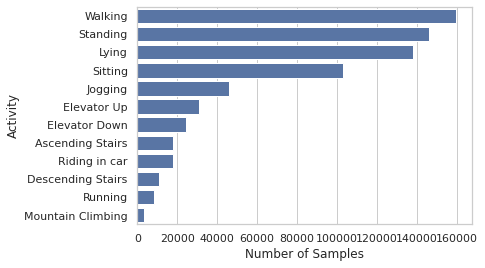

In [ ]:
sns.set(style="whitegrid", font_scale=1.0)
plot_all_activities(df)

In [ ]:
df1, df2 = split_dataset(df, 0.15)

df1_1, df1_2 = split_dataset(df1, 0.20)
#df_train, df_test = df1, df2

scale = "MinMaxScaler"
scale = "Robust"
scale = "Standard"
df_train, df_val,  df_test = standardize_dataset(df1_1, df1_2, df2, scale)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [ ]:
def plot_sensor_data(df, sensor_type, prefix='', ylabel=''):
    sns.set(style="white", font_scale=1)
    if sensor_type == 'inertial':
        data = df[[prefix+'X', prefix+'Y', prefix+'Z'][:len(df.index)]]
        #data = df[[prefix+'X', prefix+'Y', prefix+'Z'][:32]]
    else:
        data = df[['lux'][:len(df.index)]]
    fig = pyplot.figure()
    axis = data.plot(subplots=True, figsize=(6, 12))
    pyplot.xlabel('no. of samples')
    #pyplot.ylabel('acceleration')
    for ax in axis:
      ax.set_ylabel(ylabel)
      ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
    

<Figure size 432x288 with 0 Axes>

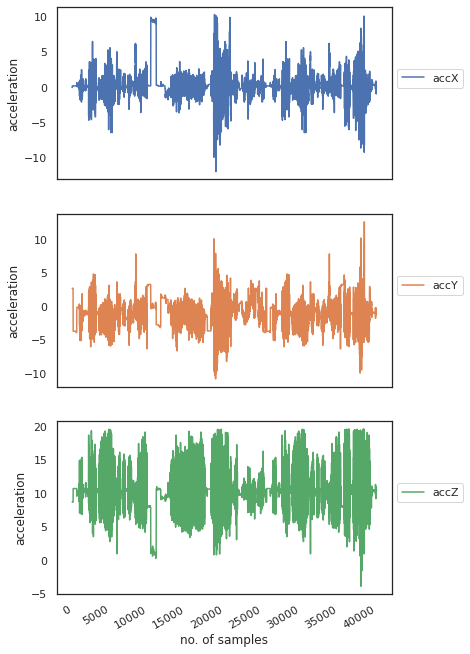

In [ ]:

concat = pd.concat([df_train, df_val,  df_test])

y_label = 'rate of rotation'
y_label = 'magnetic field strength'
y_label = 'noise level, dB'
y_label = 'illumination, lx'
y_label = 'acceleration'
#plot_sensor_data(df, 'ambient', 'soundlevel', y_label);
plot_sensor_data(df[:40000], 'inertial', 'acc', y_label);

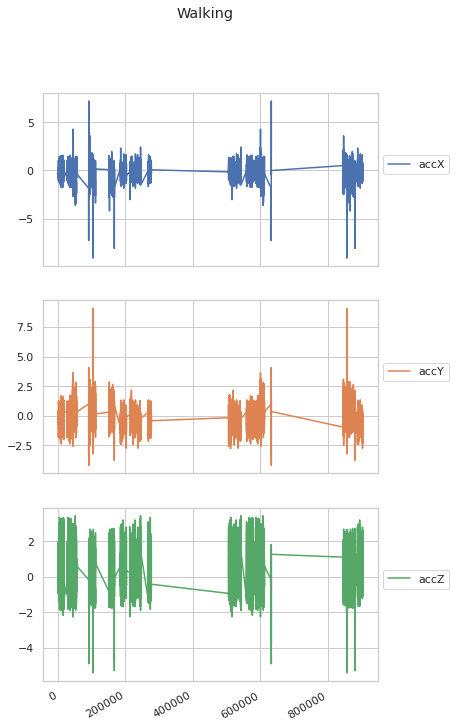

In [ ]:

concat = pd.concat([df_train, df_val,  df_test])
plot_activity("Walking", concat, 'inertial', 'acc');

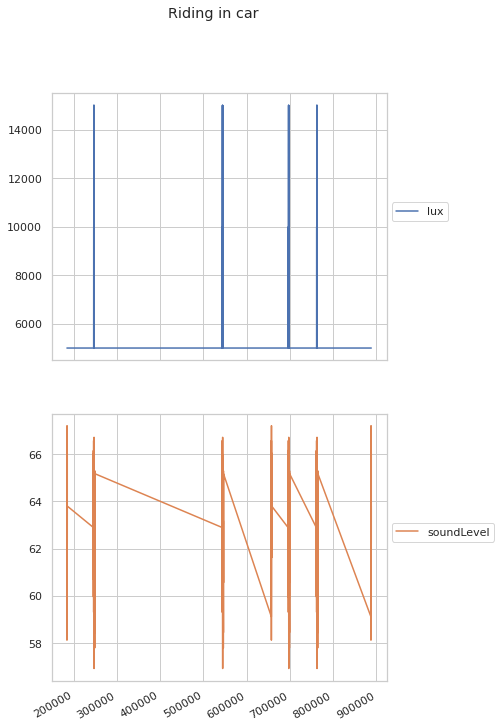

In [ ]:
plot_activity("Riding in car", df, 'ambient');

Observations: 103102
Training Observations: 103102
Testing Observations: 0


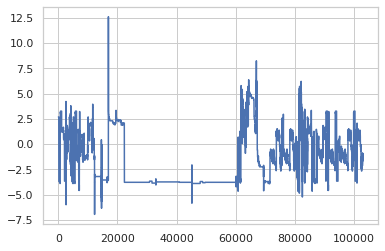

Observations: 3360
Training Observations: 3360
Testing Observations: 0


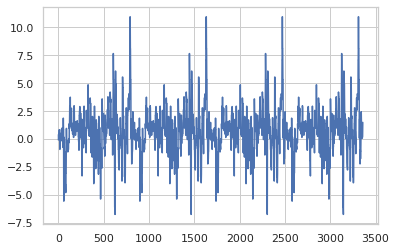

In [ ]:
plot_train_test_split(df, "Sitting", 'accY')
plot_train_test_split(df, "Mountain Climbing", 'accX')


Observations: 18000
Training Observations: 12240
Validation Observations: 3060
Testing Observations: 2700


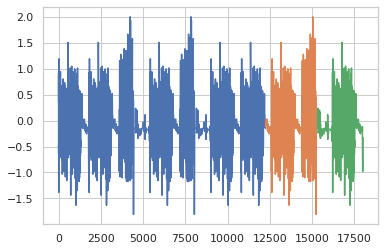

Observations: 18000
Training Observations: 12240
Validation Observations: 3060
Testing Observations: 2700


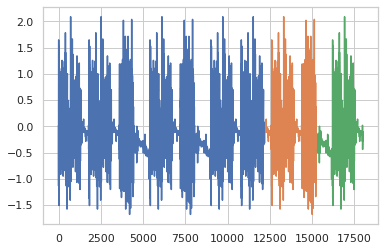

Observations: 18000
Training Observations: 12240
Validation Observations: 3060
Testing Observations: 2700


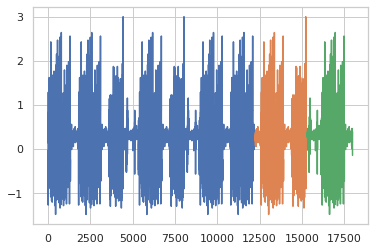

,accX,accY,accZ,gX,gY,gZ,mX,mY,mZ,lux,soundLevel,activity
0,-0.115470,1.597589,-0.340681,-0.129739,1.748843,-0.445519,-1.360638,-1.322981,-0.401542,-0.044813,-0.576488,Sitting
1,-0.115470,1.597589,-0.340681,-0.136160,1.749711,-0.443819,-1.360638,-1.342222,-0.378344,-0.044813,-0.129783,Sitting
2,-0.027312,1.597589,-0.340681,-0.137492,1.750535,-0.441892,-1.360638,-1.342222,-0.378344,-0.044813,-0.129783,Sitting
3,-0.027312,1.597589,-0.340681,-0.137492,1.750535,-0.441892,-1.360638,-1.342222,-0.378344,-0.044813,-0.579996,Sitting
4,-0.027312,1.597589,-0.340681,-0.133634,1.751145,-0.440249,-1.360638,-1.322981,-0.355146,-0.044813,-0.579996,Sitting


In [ ]:

'''
Ascending Stairs      18000
Descending Stairs     11039
Elevator Down         24118
Elevator Up           30719
Jogging               46069
Lying                138134
Mountain Climbing      3360
Riding in car         17880
Running                8274
Sitting              103102
Standing             146112
Walking              159563 
'''
concat = pd.concat([df_train, df_val,  df_test])
label ='Ascending Stairs'
sensor_mode = 'inertial'
sensor_axis = 'acc'

#sensor_mode = 'ambient'
#sensor_axis = 'soundLevel' #lux
if sensor_mode == 'inertial':
  plot_train_val_test_split(concat, label,sensor_axis+'X')
  plot_train_val_test_split(concat, label,sensor_axis+'Y')
  plot_train_val_test_split(concat, label,sensor_axis+'Z')
else:
  plot_train_val_test_split(concat, label,sensor_axis)

#df, "Mountain Climbing", 'accX'
concat.head()

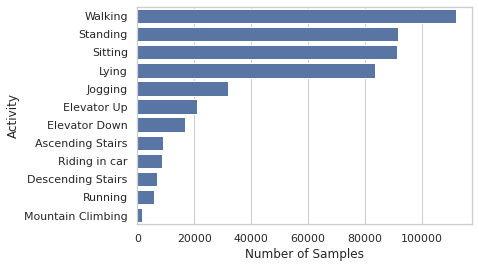

In [ ]:
sns.set(style="whitegrid", font_scale=1)
plot_all_activities(df1_1)

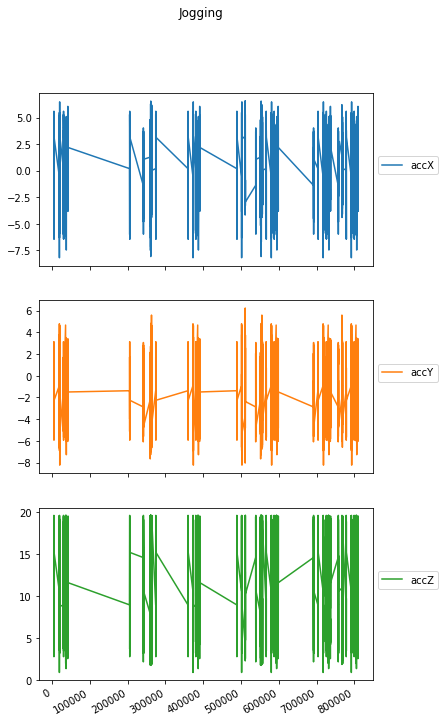

In [ ]:
# visualise effect of scaling the dataset
plot_activity("Jogging", df, 'inertial', 'acc');

Observations: 3360
Training Observations: 2352
Testing Observations: 1008


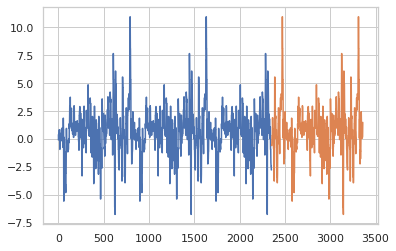

Observations: 3360
Training Observations: 2352
Testing Observations: 1008


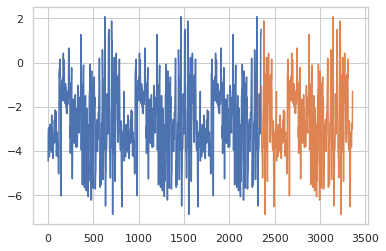

Observations: 3360
Training Observations: 2352
Testing Observations: 1008


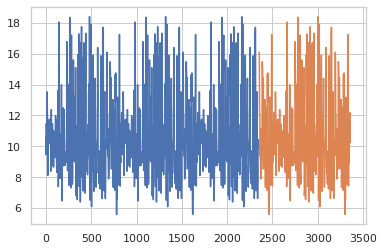

In [ ]:
plot_train_test_split(df, "Mountain Climbing", 'accX')
plot_train_test_split(df, "Mountain Climbing", 'accY')
plot_train_test_split(df, "Mountain Climbing", 'accZ')

In [ ]:
# Toggle context by removing or adding lux and noise level
# Create sliding windows and encode output label

window_length = 32
context_as_features = False
X_train, y_train, X_val, y_val, X_test, y_test = create_sliding_windows(df_train, df_val, df_test, window_length, context_as_features)

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [ ]:
print('X_train shape => ' + str(X_train.shape))
print('y_train shape => ' + str(y_train.shape))
print('X_val shape => ' + str(X_val.shape))
print('y_val shape => ' + str(y_val.shape))
print('X_test shape => ' + str(X_test.shape))
print('y_test shape => ' + str(y_test.shape))


X_train shape => (30019, 32, 9)
y_train shape => (30019, 12)
X_val shape => (7504, 32, 9)
y_val shape => (7504, 1)
X_test shape => (6621, 32, 9)
y_test shape => (6621, 12)


In [ ]:
list_har_activities(df_test)

Ascending Stairs
Descending Stairs
Elevator Down
Elevator Up
Jogging
Lying
Mountain Climbing
Riding in car
Running
Sitting
Standing
Walking


# Tuning for Learning Rate

In [ ]:
def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, n_filters, n_kernels):

  # define model
  verbose, epochs, batch_size = 1, 120, 32
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps) 

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation='relu')))   
  #model.add(TimeDistributed(Dropout(0.5)))
  model.add(TimeDistributed(MaxPooling1D()))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100))
  #model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = keras.optimizers.Adam(learning_rate=1e-8)
  #optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)

  model.compile(loss= 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  # fit network
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[lr_schedule])
  #history = model.fit(trainX, trainy, epochs=epochs,validation_data=(valX, valy), batch_size=batch_size, verbose=verbose)
  # plot learning curves
  ##pyplot.plot(history.history['accuracy'], label='train')
  ##pyplot.plot(history.history['val_accuracy'], label='test')
  ##pyplot.title('lrate='+str(lrate), pad=-50)
  return history

def run_cnn_lstm_experiment(filters, kernels):
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  return evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, filters, kernels)

  

In [ ]:
# run the experiment
n_filters = [8, 16, 32, 64, 128]
n_kernels = [2, 3, 5, 7]
n_filters = [64,128]
n_kernels = [2, 3]

n_filters = 64
n_kernels = 3

'''learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
for i in range(len(learning_rates)):
  # determine the plot number
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  # fit model and plot learning curves for a learning rate
  history = run_cnn_lstm_experiment(n_filters,n_kernels, learning_rates[i])
pyplot.show()'''
history = run_cnn_lstm_experiment(n_filters,n_kernels)


Epoch 1/120
59/59 [==============================] - 0s 6ms/step - loss: 2.5140 - accuracy: 0.0496
Epoch 2/120
59/59 [==============================] - 0s 5ms/step - loss: 2.5140 - accuracy: 0.0496
Epoch 3/120
59/59 [==============================] - 0s 6ms/step - loss: 2.5139 - accuracy: 0.0497
Epoch 4/120
59/59 [==============================] - 0s 5ms/step - loss: 2.5138 - accuracy: 0.0497
Epoch 5/120
59/59 [==============================] - 0s 6ms/step - loss: 2.5137 - accuracy: 0.0497
Epoch 6/120
59/59 [==============================] - 0s 6ms/step - loss: 2.5136 - accuracy: 0.0497
Epoch 7/120
59/59 [==============================] - 0s 5ms/step - loss: 2.5135 - accuracy: 0.0497
Epoch 8/120
59/59 [==============================] - 0s 5ms/step - loss: 2.5134 - accuracy: 0.0498
Epoch 9/120
59/59 [==============================] - 0s 6ms/step - loss: 2.5133 - accuracy: 0.0498
Epoch 10/120
59/59 [==============================] - 0s 5ms/step - loss: 2.5132 - accuracy: 0.0498
Epoch 11/

(1e-08, 0.1, 0.0, 2.7)

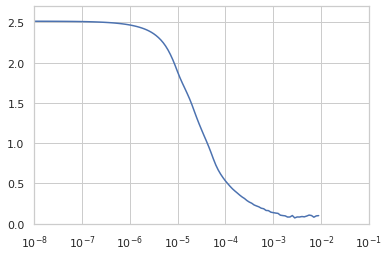

In [ ]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 2.7])

In [ ]:
def evaluate_cnn_lstm_model(trainX, trainy, testX, testy, n_filters, n_kernels):

  # define model
  verbose, epochs, batch_size = 1, 100, 32
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps ) 
  #n_steps, n_length = 4, 8

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

 # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation='relu')))
  model.add(TimeDistributed(Dropout(0.5))) 
  model.add(TimeDistributed(MaxPooling1D()))
  model.add(TimeDistributed(Flatten()))  
  model.add(LSTM(100))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  #learning_rates
  # optimizer = keras.optimizers.Adam(learning_rate=1e-3)
  optimizer='adam'

  # simple early stopping
  #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
  #mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # fit model
  #history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es, mc])
  # load the saved model
  #https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping

  
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
  # fit network
  #model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
  #early_stopping = keras.callbacks.EarlyStopping(patience=50)
  #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
  #model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", monitor='val_custom_f1', mode='max', verbose=1, save_best_only=True)

  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size,validation_split = 0.1, verbose=verbose, callbacks=[Metrics(validation=(testX, testy))])
  #history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size,  validation_data = (testX, testy) ,verbose=verbose, callbacks=[Metrics(model, valid_data)])
  #model = keras.models.load_model("my_checkpoint.h5")
  #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  y_test_pred_cat = model.predict(testX).round()
  #cm = confusion_matrix(y_test, y_test_pred_cat)
  f1_final = round(f1_score(y_test, y_test_pred_cat, average='micro'), 9)
  return history

def run_cnn_lstm_experiment(filters, kernels):
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
  return evaluate_cnn_lstm_model(trainX, trainy, testX, testy, filters, kernels)
  

In [ ]:
n_filters = 64
n_kernels = 2
history = run_cnn_lstm_experiment(n_filters,n_kernels)

validation shape 6625
Epoch 1/100
435/435 [==============================] - 5s 12ms/step - loss: 0.8660 - accuracy: 0.7267 - val_loss: 0.5804 - val_accuracy: 0.8087
Epoch 2/100
435/435 [==============================] - 4s 10ms/step - loss: 0.4787 - accuracy: 0.8479 - val_loss: 0.3664 - val_accuracy: 0.8817
Epoch 3/100
435/435 [==============================] - 4s 10ms/step - loss: 0.3533 - accuracy: 0.8849 - val_loss: 0.3322 - val_accuracy: 0.9050
Epoch 4/100
435/435 [==============================] - 4s 9ms/step - loss: 0.2764 - accuracy: 0.9093 - val_loss: 0.2749 - val_accuracy: 0.9179
Epoch 5/100
435/435 [==============================] - 4s 10ms/step - loss: 0.2260 - accuracy: 0.9295 - val_loss: 0.2206 - val_accuracy: 0.9347
Epoch 6/100
435/435 [==============================] - 4s 9ms/step - loss: 0.1897 - accuracy: 0.9383 - val_loss: 0.1747 - val_accuracy: 0.9489
Epoch 7/100
435/435 [==============================] - 4s 10ms/step - loss: 0.1528 - accuracy: 0.9483 - val_loss: 0.

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model("my_checkpoint.h5", custom_objects={"custom_f1": custom_f1})

verbose, epochs, batch_size = 1, 100, 32
trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
n_features, n_outputs = trainX.shape[2], trainy.shape[1]
n_steps = 4
n_length = int(window_length/n_steps)

testX = testX.reshape((testX.shape[0], n_steps, n_length, trainX.shape[2]))
_,f1, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

f1, accuracy

(0.9896657466888428, 0.9894355535507202)

In [ ]:
y_test_pred_cat = model.predict(testX).round()
#cm = confusion_matrix(y_test, y_test_pred_cat)
f1_final = round(f1_score(y_test, y_test_pred_cat, average='micro'), 9)
print(f'Testing F1 score = {f1_final}')

Testing F1 score = 0.989658816


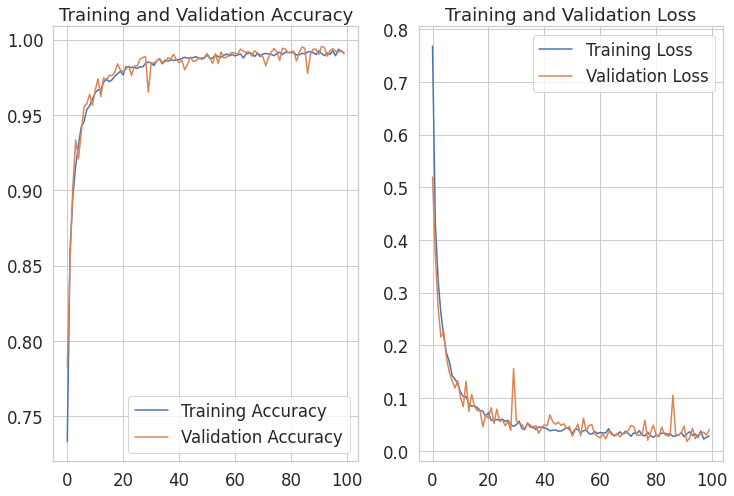

In [ ]:

acc = history.history['custom_f1']
val_acc = history.history['val_custom_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(76)
plt = pyplot
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

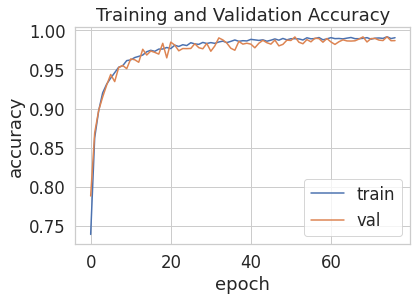

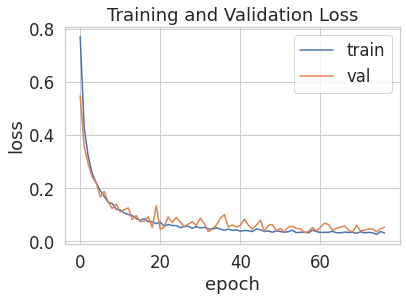

In [ ]:
plt = pyplot 
plt.plot(history.history['custom_f1'])
plt.plot(history.history['val_custom_f1'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
#trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
#cols = ['AscendingStairs','ClimbingDownStairs','ClimbingUpStairs','DescendingStairs','Driving','Hiking','Jogging','Lying','Running','Sitting','Standing']
#cols = np.sort(df_test.activity.unique()).tolist()
cols = enc.categories_[0].tolist()
Y_test = np.argmax(testy, axis=1) # Convert one-hot to index
#y_pred = model.predict_classes(testX)
y_pred = np.argmax(model.predict(testX), axis=-1)
print(classification_report(Y_test, y_pred, target_names=cols, digits=6))

                    precision    recall  f1-score   support

   AscendingStairs   0.983562  0.980874  0.982216       366
ClimbingDownStairs   0.929185  0.995402  0.961154       435
  ClimbingUpStairs   0.981949  0.978417  0.980180       556
  DescendingStairs   0.900000  0.995392  0.945295       217
           Driving   0.994350  0.990619  0.992481       533
           Jogging   0.978747  0.996583  0.987585       878
             Lying   1.000000  0.998394  0.999196      1868
  MountainClimbing   0.921875  0.983333  0.951613        60
           Running   0.993464  0.968153  0.980645       157
           Sitting   0.992063  0.992063  0.992063       630
          Standing   0.988377  0.994930  0.991642      2564
           Walking   0.999185  0.983360  0.991209      4988

          accuracy                       0.989436     13252
         macro avg   0.971896  0.988127  0.979607     13252
      weighted avg   0.989827  0.989436  0.989517     13252



In [ ]:
np.sort(df_test.activity.unique()).tolist()

['AscendingStairs',
 'ClimbingDownStairs',
 'ClimbingUpStairs',
 'DescendingStairs',
 'Driving',
 'Jogging',
 'Lying',
 'MountainAscending',
 'MountainDescending',
 'Running',
 'Sitting',
 'Standing',
 'Walking']

In [ ]:
enc.categories_[0]

array(['AscendingStairs', 'ClimbingDownStairs', 'ClimbingUpStairs',
       'DescendingStairs', 'Driving', 'Jogging', 'Lying',
       'MountainAscending', 'MountainDescending', 'Running', 'Sitting',
       'Standing', 'Walking'], dtype='<U18')

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  plt = pyplot
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

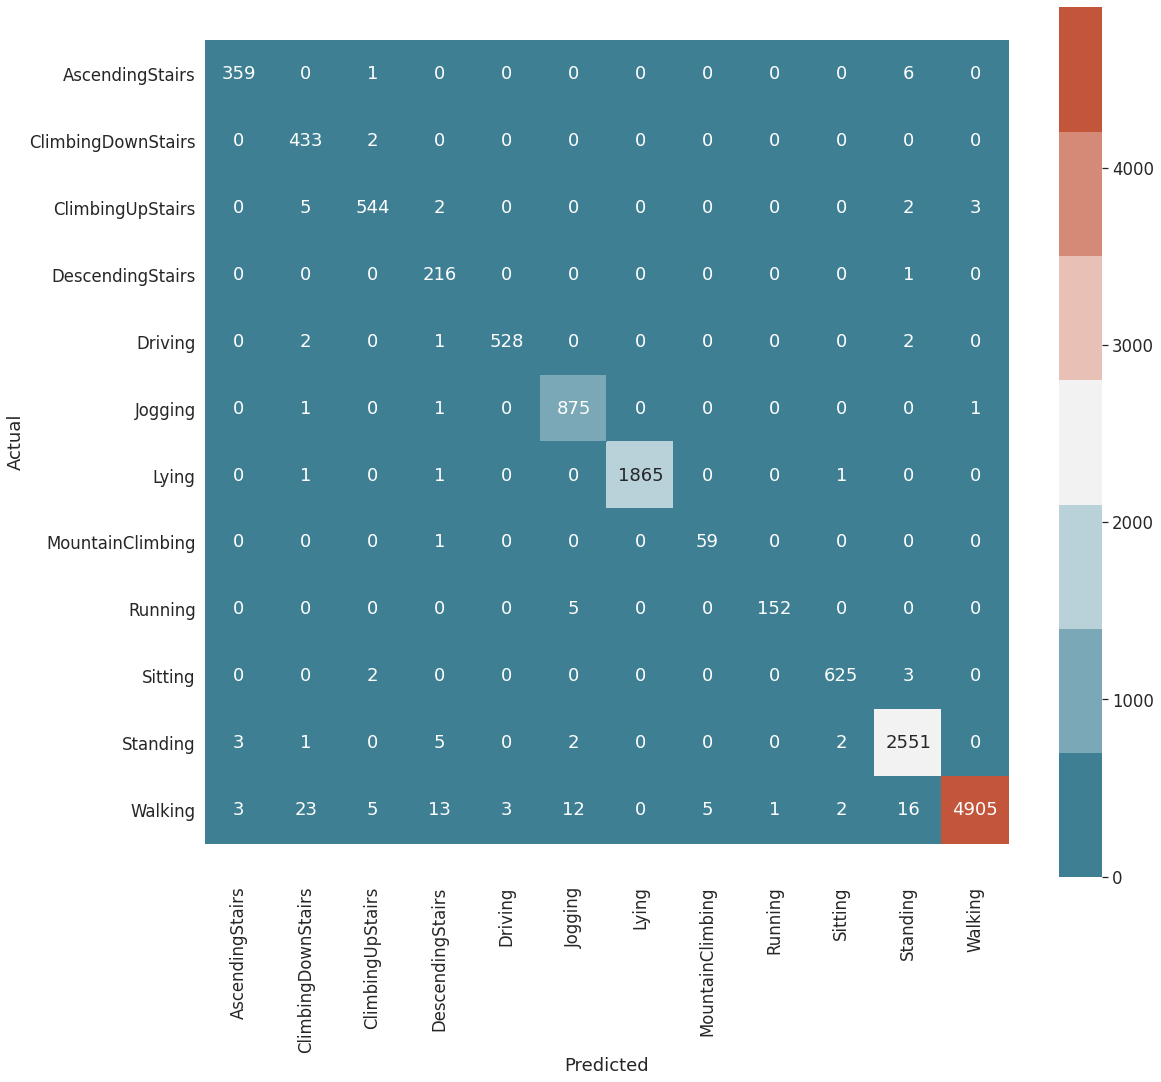

In [ ]:
y_pred = model.predict(testX, verbose=0)
plot_cm(
   
    enc.inverse_transform(y_test),
    enc.inverse_transform(y_pred),
    enc.categories_[0]
)

In [ ]:
# from AROMA plotting CM with Percentage 
def f1_score(cf_matrix, epsilon=1e-5):
    class_num = cf_matrix.shape[0]
    size = np.sum(cf_matrix)
    weights = []
    precision = []
    recall = []
    for i in range(class_num):
        tp = cf_matrix[i, i]
        tp_fp = np.sum(cf_matrix[:, i])
        tp_fn = np.sum(cf_matrix[i, :])
        weights.append(tp_fn/size)
        precision.append(tp/(tp_fp+epsilon))
        recall.append(tp/(tp_fn+epsilon))
    weights = np.asarray(weights, dtype=np.float32)
    precision = np.asarray(precision, dtype=np.float32)
    recall = np.asarray(recall, dtype=np.float32)
    f1 = 2 * (precision*recall) / (precision+recall+epsilon)
    macro_f1 = weights * f1
    return np.sum(macro_f1)

# REVISE CODE USING F-SCORE for accuracy


In [ ]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session 
import numpy as np
#from tensorflow import keras
#from tensorflow.keras import layers
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv

from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler

import pandas as pd
import seaborn as sns
from pickle import dump
from pickle import load
from keras.regularizers import l2

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

keras = tf.keras
layers = tf.keras.layers
Conv1D = layers.Conv1D
Input = layers.Input

Dense = layers.Dense
Flatten = layers.Flatten
Dropout = layers.Dropout
MaxPooling1D = layers.MaxPooling1D
concatenate = layers.concatenate
Sequential = tf.keras.Sequential
TimeDistributed = layers.TimeDistributed
LSTM = layers.LSTM
ConvLSTM2D = layers.ConvLSTM2D


to_categorical = tf.keras.utils.to_categorical
plot_model = tf.keras.utils.plot_model

In [ ]:
import pandas as pd
def load_dataset():
    filepath = '/content/drive/My Drive/HAR_Project/Dataset/custom_yomi/HARContextData.csv'
    #filepath = '../../Dataset\custom_dataset_yomi/processed/HARContextData.csv'
    df = pd.read_csv(filepath)
    return df

def list_har_activities(df):
  activities = df['activity'].unique()
  for i in sorted(activities):
      print (i)

#show rows with null values 
def show_null_values(df):
  df2 = df[df.isnull().any(axis=1)]
  df2.head(50000)   
  #it appears _id is the culprit here.

def plot_all_activities(df):
    
    sns.countplot(y = 'activity',
                  data = df, palette=[sns.color_palette()[0]],
                  order = df.activity.value_counts().index)
    
    pyplot.ylabel("Activity")
    pyplot.xlabel("Number of Samples")
    #plt.title("Samples per activity")


def plot_activity(activity, df, sensor_type, prefix=''):
    if sensor_type == 'inertial':
        data = df[df['activity'] == activity][[prefix+'X', prefix+'Y', prefix+'Z']][:len(df.index)]
    else:
        data = df[df['activity'] == activity][['lux', 'soundLevel']][:len(df.index)]
    
    axis = data.plot(subplots=True, figsize=(6, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

        
#split dataset into training and test
#test_size = 0.1
from sklearn.model_selection import train_test_split
def split_dataset(df, test_size=0.3):
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=45, shuffle = False)
    return df_train, df_test


def plot_train_test_split(df, activity, sensor_axis, test_size=0.15): 
    
    df = df[df['activity'] == activity][df.columns[:11]]
    #series = read_csv('sunspots.csv', header=0, index_col=0)
    X = df[sensor_axis].values
    
    train_size = int(len(X) * (1-test_size))
    train, test = X[0:train_size], X[train_size:len(X)]
   
    print('Observations: %d' % (len(X)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    pyplot.show()



def plot_train_val_test_split(df, activity, sensor_axis, test_size=0.15, val_split=0.2): 
    
    df = df[df['activity'] == activity][df.columns[:11]]
    #series = read_csv('sunspots.csv', header=0, index_col=0)
    X = df[sensor_axis].values
    
    train_size = int(len(X) * (1-test_size) * (1-val_split))
    val_size = int(len(X) * (1-test_size)* val_split)


    train, val, test = X[0:train_size], X[train_size:train_size+val_size], X[train_size+val_size:len(X)]
    train_val = X[0:train_size+val_size]
   
    print('Observations: %d' % (len(X)))
    print('Training Observations: %d' % (len(train)))
    print('Validation Observations: %d' % (len(val)))
    print('Testing Observations: %d' % (len(test)))
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in val])
    pyplot.plot([None for i in train_val] + [x for x in test])
    pyplot.show()

    #The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

#standardize dataset to improve model classification accuracy
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
def standardize_dataset(df_train, df_val, df_test, scale_type):

    scale_columns = ['accX','accY','accZ','gX','gY','gZ','mX','mY','mZ','lux','soundLevel']
    if scale_type == "Robust":
        scaler = RobustScaler()
    elif scale_type == "MinMaxScaler":
        scaler = MinMaxScaler()
    elif scale_type == "Standard":
        scaler = StandardScaler()
        
    scaler = scaler.fit(df_train[scale_columns])

    df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
    df_val.loc[:, scale_columns] = scaler.transform(df_val[scale_columns].to_numpy())
    df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

    return df_train, df_val, df_test


from scipy import stats
from sklearn.preprocessing import OneHotEncoder

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)


def create_sliding_windows(df_train, df_val, df_test, window_length = 64, context = True):
    #best config [time_step=64, step=32]
    TIME_STEPS = window_length   
    # to create overlap, divide, use 50% of window length
    STEP = int(TIME_STEPS/2)
    if context:
      cols = ['accX','accY','accZ','gX','gY','gZ','mX','mY','mZ','lux','soundLevel']
    else:
      cols = ['accX','accY','accZ','gX','gY','gZ','mX','mY','mZ']

    X_train, y_train = create_dataset(
      df_train[cols],
      df_train.activity, 
      TIME_STEPS, 
      STEP
    )

    X_val, y_val = create_dataset(
      df_val[cols],
      df_val.activity, 
      TIME_STEPS, 
      STEP
    )

    X_test, y_test = create_dataset(
      df_test[cols], 
      df_test.activity, 
      TIME_STEPS, 
      STEP
    )
    #y_train, y_test = encode_dataset(y_train, y_test)  
    return X_train, y_train, X_val, y_val, X_test, y_test

def encode_dataset(y_train, y_val, y_test):
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

    enc = enc.fit(y_train)

    y_train = enc.transform(y_train)
    y_val = enc.transform(y_val)
    y_test = enc.transform(y_test)
    return y_train, y_test
    #print('ds:',X_train.shape, X_test.shape)


def load_preprocessed_data():
  #df_train, df_test = load_dataset()
  return create_sliding_windows(df_train, df_val, df_test)

def update_activity_lables(data, prefix = False):
  if prefix == True:
    simple_label = '1-'
    complex_label = '2-'
  else:
    simple_label = complex_label = ''

  data.loc[(data.activity.isin(['MountainDescending']),'activity')] = complex_label + 'Mountain Climbing'
  data.loc[(data.activity.isin(['AscendingStairs']),'activity')] = complex_label + 'Ascending Stairs'
  data.loc[(data.activity.isin(['DescendingStairs']),'activity')] = complex_label + 'Descending Stairs'
  data.loc[(data.activity.isin(['Driving']),'activity')] = complex_label + 'Riding in car'
  data.loc[(data.activity.isin(['ClimbingDownStairs']),'activity')] = complex_label + 'Elevator Down'
  data.loc[(data.activity.isin(['ClimbingUpStairs']),'activity')] = complex_label + 'Elevator Up'
  data.loc[(data.activity.isin(['Jogging']),'activity')] = simple_label + 'Jogging'
  data.loc[(data.activity.isin(['Lying']),'activity')] = simple_label + 'Lying'
  data.loc[(data.activity.isin(['Running']),'activity')] = simple_label + 'Running'
  data.loc[(data.activity.isin(['Sitting']),'activity')] = simple_label + 'Sitting'
  data.loc[(data.activity.isin(['Standing']),'activity')] = simple_label + 'Standing'
  data.loc[(data.activity.isin(['Walking']),'activity')] = simple_label + 'Walking'
  return data
# Update the MountainAscending and MountainDescending to MountainClimbing
def augment_dataset(df, prefix_label=True):

  #df.loc[(df.activity.isin(['MountainDescending', 'MountainAscending']),'activity')] = 'MountainClimbing'
  #df = df[df.activity !='MountainClimbing']
  
  #exclude mountain ascending from the analysis due to few samples
  df = df[df.activity !='MountainAscending']

  # Down-Sampling the Walking Activity Data
  df_walking = df[df.activity == 'Walking']
  df_walking['index1'] = df_walking.index
  dfs = np.array_split(df_walking, 9)
  i = 0
  for d in dfs:
      i = i+1
      #[1,2,3,4,5,6,7,8,9]
      if i in [3,4,5,7,8]:        
          df = df.drop(d.index1, axis=0) #df_train.drop(wrong_indexes_train,axis=1)

  #update the activity labels        
  return update_activity_lables(df, prefix_label)


# Custom F-Score for model evaluation: https://towardsdatascience.com/implementing-macro-f1-score-in-keras-what-not-to-do-e9f1aa04029d
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score, recall_score, precision_score
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    #val_f1 = f1_score(y_true, y_pred, average='micro')
    #return val_f1


def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        #print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        val_f1 = f1_score(val_targ, val_predict, average='macro')
        val_recall = recall_score(val_targ, val_predict,  average='macro')         
        val_precision = precision_score(val_targ, val_predict,  average='macro')
        
        self.val_f1s.append(round(val_f1, 6))
        self.val_recalls.append(round(val_recall, 6))
        self.val_precisions.append(round(val_precision, 6))
 
        #print(f' — val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}')

In [ ]:
window_length = 32 #optimal window length is 32
df = load_dataset()
df = augment_dataset(df, True)
df1, df2 = split_dataset(df, 0.15)
# split train into train and valid 
df1_1, df1_2 = split_dataset(df1, 0.20)

df_train, df_val, df_test = standardize_dataset(df1_1, df1_2, df2, 'Standard')

context_as_features = False
X_train, y_train, X_val, y_val, X_test, y_test = create_sliding_windows(df_train, df_val, df_test, window_length, context_as_features)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

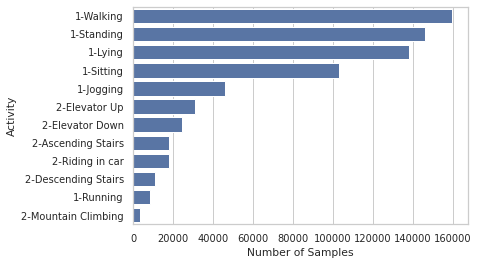

In [ ]:
sns.set(style="whitegrid", font_scale=0.9)
plot_all_activities(df)

In [ ]:
# summarize class balance from the har dataset
from numpy import vstack

# summarize the balance of classes in an output variable column
def class_breakdown(data):
	# convert the numpy array into a dataframe
	df = pd.DataFrame(data)
	# group data by the class value and calculate the number of rows
	counts = df.groupby(0).size()
	# retrieve raw rows
	counts = counts.values
	# summarize
	for i in range(len(counts)):
		percent = counts[i] / len(df) * 100
		print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

# load train file
#trainy = load_file('../../../../Dataset/HAR_Smartphones/UCI HAR Dataset/train/y_train.txt')
trainy = y_train
# summarize class breakdown
print('Train Dataset')
class_breakdown(trainy)

# load train file
#trainy = load_file('../../../../Dataset/HAR_Smartphones/UCI HAR Dataset/train/y_train.txt')
valy = y_val
# summarize class breakdown
print('Validation Dataset')
class_breakdown(valy)

# load test file
#testy = load_file('../../../../Dataset/HAR_Smartphones/UCI HAR Dataset/test/y_test.txt')
testy = y_test
# summarize class breakdown
print('Test Dataset')
class_breakdown(testy)

# summarize combined class breakdown
print('All')
combined = vstack((trainy, valy, testy))
class_breakdown(combined)

Train Dataset
Class=1, total=2011, percentage=6.699
Class=2, total=5229, percentage=17.419
Class=3, total=359, percentage=1.196
Class=4, total=5716, percentage=19.041
Class=5, total=5732, percentage=19.095
Class=6, total=6995, percentage=23.302
Class=7, total=560, percentage=1.865
Class=8, total=427, percentage=1.422
Class=9, total=1046, percentage=3.484
Class=10, total=1309, percentage=4.361
Class=11, total=103, percentage=0.343
Class=12, total=532, percentage=1.772
Validation Dataset
Class=1, total=554, percentage=7.383
Class=2, total=1816, percentage=24.200
Class=3, total=84, percentage=1.119
Class=4, total=539, percentage=7.183
Class=5, total=2213, percentage=29.491
Class=6, total=472, percentage=6.290
Class=7, total=450, percentage=5.997
Class=8, total=219, percentage=2.918
Class=9, total=265, percentage=3.531
Class=10, total=307, percentage=4.091
Class=11, total=52, percentage=0.693
Class=12, total=533, percentage=7.103
Test Dataset
Class=1, total=323, percentage=4.878
Class=2, t

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

# Tuning for LSTM Cells

In [ ]:

def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, n_filters=64, n_kernels=3, lstm_cells = 64):

  # define model
 
  verbose, epochs, batch_size = 0, 25, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps ) 

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

 # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation='relu')))

  model.add(TimeDistributed(Dropout(0.5))) 
  model.add(TimeDistributed(MaxPooling1D()))
  model.add(TimeDistributed(Flatten()))  
  model.add(LSTM(lstm_cells))
  model.add(Dropout(0.5))
  model.add(Dense(lstm_cells, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))


  #learning_rates
  # optimizer = keras.optimizers.Adam(learning_rate=1e-3)
  optimizer='adam'
  plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/HAR_Project/images/baseline_model/cnn-lstm.png')
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
  #model.compile(optimizer=optimizer,  loss=f1_loss, metrics=[f1])

  # fit network
  #model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
  #early_stopping = keras.callbacks.EarlyStopping(patience=5)

  # simple early stopping
  #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
  #mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # fit model
  #history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es, mc])
  # load the saved model
  #https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping
  
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=5)
  mc = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", monitor='val_accuracy', mode='max', verbose=verbose, save_best_only=True)

  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])
  #history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])

  #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  model = keras.models.load_model("my_checkpoint.h5")
  #model = keras.models.load_model("my_checkpoint.h5", custom_objects={"custom_f1": custom_f1})

  y_test_pred_cat = model.predict(testX).round()
  f1_final = round(f1_score(y_test, y_test_pred_cat, average='macro'), 4)
  return f1_final



def summarize_results(scores, params, filter):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	fig = pyplot.figure()
	pyplot.boxplot(scores, labels=params)
#	pyplot.xlabel('no_of_kernels')
#	pyplot.ylabel('avg_accuracy')
	fig.savefig('/content/drive/My Drive/HAR_Project/images/baseline_model/'+'20200824_cnn_lstm_filters_' + str(filter)+'.png')
	#pyplot.savefig('/content/drive/My Drive/HAR_Project/images/baseline_model'+'exp_cnn_lstm_filters_' + str(filter)+'.png')
	fig.clear()
	pyplot.close('all')
	pyplot.close(fig)

# run an experiment
def run_cnn_lstm_experiment(filters, kernels, repeats=1):
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test

  all_scores = list()
  # run for different filters
  for f in filters:
    f_scores = list()
    # run for different kernel
    for k in kernels:
      k_scores = list()
      for r in range(repeats):
        score = evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, f, k)
        score = score * 100.0
        #print('>#%d: %.3f' % (r+1, score))
        print('>filter=%d, kernel=%d #%d: %.3f' % (f, k, r+1, score))
        k_scores.append(score)
      f_scores.append(k_scores)
    
    all_scores.append(f_scores)
		# summarize results 
    summarize_results(f_scores, kernels, f)
		
  print(all_scores, filters, kernels)


# Investigating for optimal window length
def run_lstm_cells(repeats=1):
#load data
#trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  lstm_cells = [16,32,64,100,128,256]
  lstm_cells = [256, 512, 1024]
  all_scores = list()
  
  for lstm in lstm_cells:
    f_scores = list()
    # repeat experiment
    for r in range(repeats):
      score = evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, lstm)
      score = score * 100.0
      #print('>#%d: %.3f' % (r+1, score))
      
      print('>lstm_cell: {}, #{}: {}'.format(lstm, r+1, score))
      #>window length:128 filter=64, kernel=3 #4: 97.670
      f_scores.append(score)
    all_scores.append(f_scores)
	
  print(all_scores, lstm_cells)  

In [ ]:
run_lstm_cells()

>lstm_cell: 256, #1: 96.25
>lstm_cell: 512, #1: 95.77
>lstm_cell: 1024, #1: 96.04
[[96.25], [95.77], [96.04]] [256, 512, 1024]


# Tuning for Window Length

In [ ]:

def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, n_filters=64, n_kernels=3, batch_size = 64):

  # define model
 
  verbose, epochs, batch_size = 0, 25, batch_size
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps ) 

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

 # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation='relu')))

  model.add(TimeDistributed(Dropout(0.5))) 
  model.add(TimeDistributed(MaxPooling1D()))
  model.add(TimeDistributed(Flatten()))  
  model.add(LSTM(100))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))


  #learning_rates
  # optimizer = keras.optimizers.Adam(learning_rate=1e-3)
  optimizer='adam'
  plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/HAR_Project/images/baseline_model/cnn-lstm.png')
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
  #model.compile(optimizer=optimizer,  loss=f1_loss, metrics=[f1])

  # fit network
  #model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
  #early_stopping = keras.callbacks.EarlyStopping(patience=5)

  # simple early stopping
  #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
  #mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # fit model
  #history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es, mc])
  # load the saved model
  #https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping
  
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=5)
  mc = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", monitor='val_accuracy', mode='max', verbose=verbose, save_best_only=True)

  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[Metrics(validation=(valX, valy)), mc, es])
  #history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])

  #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  model = keras.models.load_model("my_checkpoint.h5")
  #model = keras.models.load_model("my_checkpoint.h5", custom_objects={"custom_f1": custom_f1})

  y_test_pred_cat = model.predict(testX).round()
  f1_final = round(f1_score(y_test, y_test_pred_cat, average='macro'), 4)
  return f1_final



def summarize_results(scores, params, filter):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	fig = pyplot.figure()
	pyplot.boxplot(scores, labels=params)
#	pyplot.xlabel('no_of_kernels')
#	pyplot.ylabel('avg_accuracy')
	fig.savefig('/content/drive/My Drive/HAR_Project/images/baseline_model/'+'20200824_cnn_lstm_filters_' + str(filter)+'.png')
	#pyplot.savefig('/content/drive/My Drive/HAR_Project/images/baseline_model'+'exp_cnn_lstm_filters_' + str(filter)+'.png')
	fig.clear()
	pyplot.close('all')
	pyplot.close(fig)

# run an experiment
def run_cnn_lstm_experiment(filters, kernels, repeats=1):
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test

  all_scores = list()
  # run for different filters
  for f in filters:
    f_scores = list()
    # run for different kernel
    for k in kernels:
      k_scores = list()
      for r in range(repeats):
        score = evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, f, k)
        score = score * 100.0
        #print('>#%d: %.3f' % (r+1, score))
        print('>filter=%d, kernel=%d #%d: %.3f' % (f, k, r+1, score))
        k_scores.append(score)
      f_scores.append(k_scores)
    
    all_scores.append(f_scores)
		# summarize results 
    summarize_results(f_scores, kernels, f)
		
  print(all_scores, filters, kernels)


# Investigating for optimal window length
def run_window_length(window_length, repeats=10):
#load data
#trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  batch_size = [16,32,64,128,256]
  all_scores = list()
  
  for batch in batch_size:
    f_scores = list()
    # repeat experiment
    for r in range(repeats):
      score = evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, batch)
      score = score * 100.0
      #print('>#%d: %.3f' % (r+1, score))
      
      print('>window length: {}, batch_size: {}, #{}: {}'.format(window_length, batch, r+1, score))
      #>window length:128 filter=64, kernel=3 #4: 97.670
      f_scores.append(score)
    all_scores.append(f_scores)
	
  print(all_scores, batch_size, [window_length])  

In [ ]:
# Run Experiment for window_length

run_window_length(window_length)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>window length: 64, batch_size: 16, #1: 96.65
>window length: 64, batch_size: 16, #2: 96.14
>window length: 64, batch_size: 16, #3: 95.39999999999999
>window length: 64, batch_size: 16, #4: 96.44
>window length: 64, batch_size: 16, #5: 96.63000000000001
>window length: 64, batch_size: 16, #6: 96.88
>window length: 64, batch_size: 16, #7: 95.86
>window length: 64, batch_size: 16, #8: 96.66
>window length: 64, batch_size: 16, #9: 95.16
>window length: 64, batch_size: 16, #10: 94.78999999999999
>window length: 64, batch_size: 32, #1: 97.68
>window length: 64, batch_size: 32, #2: 97.19
>window length: 64, batch_size: 32, #3: 97.23
>window length: 64, batch_size: 32, #4: 97.09
>window length: 64, batch_size: 32, #5: 97.49
>window length: 64, batch_size: 32, #6: 97.61999999999999
>window length: 64, batch_size: 32, #7: 97.35000000000001
>window length: 64, batch_size: 32, #8: 97.76
>window length: 64, batch_size: 32, #9: 97.15
>window length: 64, batch_size: 32, #10: 97.57000000000001
>windo

In [ ]:

def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, n_filters=64, n_kernels=3, batch_size = 64):

  # define model
 
  verbose, epochs, batch_size = 0, 300, batch_size
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps ) 

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

 # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation='relu')))

  #model.add(TimeDistributed(Dropout(0.5))) 
  model.add(TimeDistributed(MaxPooling1D()))
  model.add(TimeDistributed(Flatten()))  
  model.add(LSTM(100))
  #model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  optimizer = keras.optimizers.Adam(lr=1e-3)
  
  #model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])
  
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=20)
  mc = keras.callbacks.ModelCheckpoint("no_context.h5", monitor='val_custom_f1', mode='max', verbose=verbose, save_best_only=True)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])

  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])

  print('training completed...')
  return history
# Investigating for optimal window length
def run_window_length(batch):
#load data
#trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  
  return evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, batch)
   

In [ ]:
window_length=32
batch = 512
history = run_window_length(batch)

training completed...


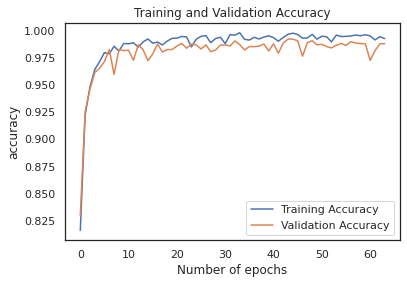

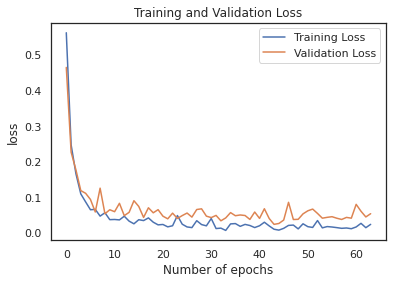

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

acc = history.history['custom_f1']
val_acc = history.history['val_custom_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']
sns.set(style="white", font_scale=1)
#epochs_range = range(76)
plt = pyplot 
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Number of epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('Number of epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Tuning for overfitting - Learning Rate


In [ ]:
def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, lrate):

  # define model
  verbose, epochs, batch_size = 1, 120, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps )

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu')))   
  model.add(TimeDistributed(Dropout(0.5)))
  model.add(TimeDistributed(MaxPooling1D()))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = keras.optimizers.Adam(lr=1e-8)

  #optimizer = keras.optimizers.Adam(learning_rate=lrate)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])

  # fit network
  #history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[lr_schedule])
  #history = model.fit(trainX, trainy, epochs=epochs,validation_data=(testX, testy), batch_size=batch_size, verbose=verbose)
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[lr_schedule])
  
  '''
  # plot learning curves
  pyplot.plot(history.history['accuracy'], label='train')
  pyplot.plot(history.history['val_accuracy'], label='validation')
  pyplot.title('lrate='+str(lrate), pad=-50)
  '''
  return history

def run_cnn_lstm_experiment(lrate=0.0001):
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  return evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, lrate)

  

In [ ]:
history = run_cnn_lstm_experiment()

Epoch 1/120
470/470 [==============================] - 4s 9ms/step - loss: 2.5135 - accuracy: 0.0641 - custom_f1: 0.0000e+00 - val_loss: 2.4637 - val_accuracy: 0.1799 - val_custom_f1: 0.0000e+00
Epoch 2/120
470/470 [==============================] - 3s 7ms/step - loss: 2.5122 - accuracy: 0.0645 - custom_f1: 0.0000e+00 - val_loss: 2.4635 - val_accuracy: 0.1798 - val_custom_f1: 0.0000e+00
Epoch 3/120
470/470 [==============================] - 3s 7ms/step - loss: 2.5131 - accuracy: 0.0633 - custom_f1: 0.0000e+00 - val_loss: 2.4632 - val_accuracy: 0.1799 - val_custom_f1: 0.0000e+00
Epoch 4/120
470/470 [==============================] - 3s 7ms/step - loss: 2.5123 - accuracy: 0.0629 - custom_f1: 0.0000e+00 - val_loss: 2.4629 - val_accuracy: 0.1802 - val_custom_f1: 0.0000e+00
Epoch 5/120
470/470 [==============================] - 3s 7ms/step - loss: 2.5116 - accuracy: 0.0624 - custom_f1: 0.0000e+00 - val_loss: 2.4626 - val_accuracy: 0.1811 - val_custom_f1: 0.0000e+00
Epoch 6/120
470/470 [====

(1e-08, 0.1, 0.0, 3.0)

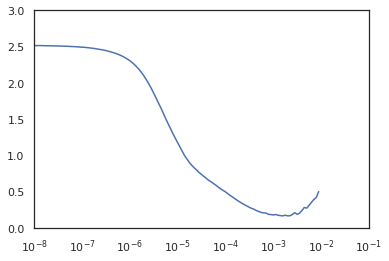

In [ ]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 3])


In [ ]:

def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy):

  # define model
  verbose, epochs, batch_size = 1, 100, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps )

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu')))   
  model.add(TimeDistributed(Dropout(0.5)))
  model.add(TimeDistributed(MaxPooling1D()))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  #lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = keras.optimizers.Adam(lr=1e-3)
  #optimizer = keras.optimizers.Adam(lr=5e-4)

  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=8)
  mc = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", monitor='val_accuracy', mode='max', verbose=verbose, save_best_only=True)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])

  # fit network  
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])
  #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  #model = keras.models.load_model("my_checkpoint.h5")
  return history

def run_cnn_lstm_experiment():
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  return evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy)

  

In [ ]:
history = run_cnn_lstm_experiment()

Epoch 1/100
464/470 [============================>.] - ETA: 0s - loss: 0.8621 - accuracy: 0.7329 - custom_f1: 0.7020
Epoch 00001: val_accuracy improved from -inf to 0.74454, saving model to my_checkpoint.h5
470/470 [==============================] - 4s 9ms/step - loss: 0.8581 - accuracy: 0.7340 - custom_f1: 0.7041 - val_loss: 0.7889 - val_accuracy: 0.7445 - val_custom_f1: 0.6985
Epoch 2/100
464/470 [============================>.] - ETA: 0s - loss: 0.4838 - accuracy: 0.8464 - custom_f1: 0.8482
Epoch 00002: val_accuracy improved from 0.74454 to 0.80730, saving model to my_checkpoint.h5
470/470 [==============================] - 4s 8ms/step - loss: 0.4836 - accuracy: 0.8464 - custom_f1: 0.8480 - val_loss: 0.5641 - val_accuracy: 0.8073 - val_custom_f1: 0.7732
Epoch 3/100
469/470 [============================>.] - ETA: 0s - loss: 0.3712 - accuracy: 0.8801 - custom_f1: 0.8811
Epoch 00003: val_accuracy improved from 0.80730 to 0.86487, saving model to my_checkpoint.h5
470/470 [==============

In [ ]:
model = keras.models.load_model("my_checkpoint.h5", custom_objects={"custom_f1": custom_f1})

batch_size = 64
trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
n_features, n_outputs = trainX.shape[2], trainy.shape[1]
n_steps = 4
n_length = int(window_length/n_steps)

testX = testX.reshape((testX.shape[0], n_steps, n_length, trainX.shape[2]))
_, accuracy, f1 = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
accuracy, f1

(0.9900317192077637, 0.9900746941566467)

In [ ]:
# make a prediction
#ynew = model.predict_classes(testX)


In [ ]:
y_test_pred_cat = model.predict(testX).round()
#cm = confusion_matrix(y_test, y_test_pred_cat)
f1_final = round(f1_score(y_test, y_test_pred_cat, average='macro'), 9)
print(f'Testing F1 score = {f1_final}')

Testing F1 score = 0.966175836


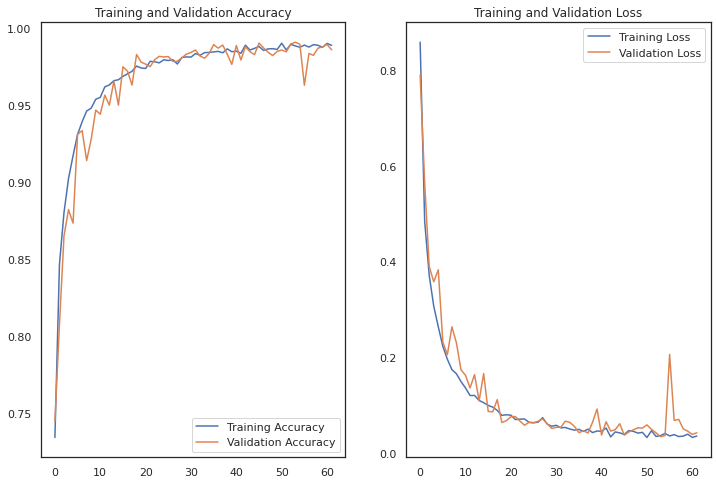

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(76)
plt = pyplot
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

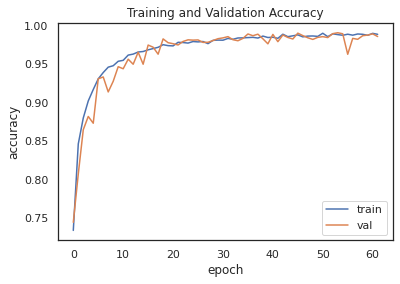

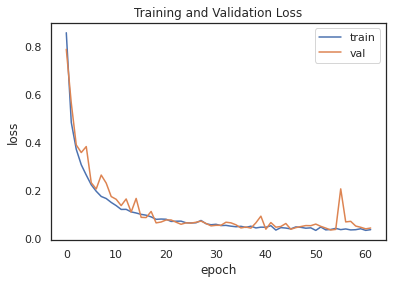

In [ ]:
plt = pyplot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Dropout Regularisation




In [ ]:
window_length = 32 #optimal window length is 32
df = load_dataset()
df = augment_dataset(df, False)
df1, df2 = split_dataset(df, 0.15)
# split train into train and valid 
df1_1, df1_2 = split_dataset(df1, 0.20)

df_train, df_val, df_test = standardize_dataset(df1_1, df1_2, df2, 'Standard')

context_as_features = False
X_train, y_train, X_val, y_val, X_test, y_test = create_sliding_windows(df_train, df_val, df_test, window_length, context_as_features)


enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [ ]:
from keras.layers import SpatialDropout1D
def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, drop):

  # define model
  verbose, epochs, batch_size = 0, 25, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps )

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu'))) 
  model.add(TimeDistributed(Dropout(drop)))
  model.add(TimeDistributed(MaxPooling1D()))
  
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100))
  #model.add(Dropout(dropout))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  #lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = keras.optimizers.Adam(lr=1e-3)
  #optimizer = keras.optimizers.Adam(lr=5e-4)

  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=5)
  mc = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", monitor='val_custom_f1', mode='max', verbose=verbose, save_best_only=True)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])

  # fit network  
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])
  #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  #model = keras.models.load_model("my_checkpoint.h5")



 # model = keras.models.load_model("my_checkpoint.h5")
  model = keras.models.load_model("my_checkpoint.h5", custom_objects={"custom_f1": custom_f1})

  _, train_acc, train_f1 = model.evaluate(trainX, trainy, verbose=0)
  _, val_acc, val_f1 = model.evaluate(valX, valy, verbose=0)

  #acc = history.history['custom_f1']
  #val_acc = history.history['val_custom_f1']

  #loss = history.history['loss']
  #val_loss = history.history['val_loss']

  y_test_pred_cat = model.predict(testX).round()
  #cm = confusion_matrix(y_test, y_test_pred_cat)
  test_f1 = round(f1_score(y_test, y_test_pred_cat, average='macro'), 9)
  return  train_f1, val_f1 , test_f1

def run_cnn_lstm_experiment():
  dropout = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  #dropout = [0.0]

  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()

  f_scores = list()
  train_scores = []
  val_scores = []
  test_scores = []
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  for drop in dropout:    
    drop = float(drop)
    train_acc, val_acc, f1_final =  evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, drop)
    print ('Dropout: {} train_acc: {} val_acc: {} f1_final: {}'.format(drop, train_acc, val_acc, f1_final))
    train_scores.append(train_acc)
    val_scores.append(val_acc)
    test_scores.append(f1_final)
  f_scores.append(train_scores)
  f_scores.append(val_scores)
  f_scores.append(test_scores)
  print(f_scores, dropout)

  

In [ ]:
history = run_cnn_lstm_experiment()

Dropout: 0.0 train_acc: 0.9958479404449463 val_acc: 0.9898070693016052 f1_final: 0.957051329
Dropout: 0.1 train_acc: 0.9957343935966492 val_acc: 0.9900621771812439 f1_final: 0.964112736
Dropout: 0.2 train_acc: 0.992435097694397 val_acc: 0.9875606894493103 f1_final: 0.953551757
Dropout: 0.3 train_acc: 0.981830358505249 val_acc: 0.9741777777671814 f1_final: 0.933964311
Dropout: 0.4 train_acc: 0.9874019026756287 val_acc: 0.9781744480133057 f1_final: 0.954352491
Dropout: 0.5 train_acc: 0.9890416860580444 val_acc: 0.9845110774040222 f1_final: 0.940882471
Dropout: 0.6 train_acc: 0.9816146492958069 val_acc: 0.9627888202667236 f1_final: 0.95165108
Dropout: 0.7 train_acc: 0.9857161045074463 val_acc: 0.9776838421821594 f1_final: 0.930443331
Dropout: 0.8 train_acc: 0.9727330207824707 val_acc: 0.9622369408607483 f1_final: 0.888390406
Dropout: 0.9 train_acc: 0.9023904204368591 val_acc: 0.8626922369003296 f1_final: 0.70705233
[[0.9958479404449463, 0.9957343935966492, 0.992435097694397, 0.98183035850

In [ ]:
def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy):

  # define model
  verbose, epochs, batch_size = 0, 100, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps )

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu'), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu'))) 
  
  model.add(TimeDistributed(Dropout(0.1)))
  model.add(TimeDistributed(MaxPooling1D()))
  
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100))
  #model.add(Dropout(0.3))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  #lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = keras.optimizers.Adam(lr=1e-3)
  #optimizer = keras.optimizers.Adam(lr=5e-4)

  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=5)
  mc = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", monitor='val_custom_f1', mode='max', verbose=verbose, save_best_only=True)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])

  # fit network  
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])
  return  history

def run_cnn_lstm_experiment():
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()
  allscores = list()
  f_scores = list()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  return evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy)
  

In [ ]:
history = run_cnn_lstm_experiment()

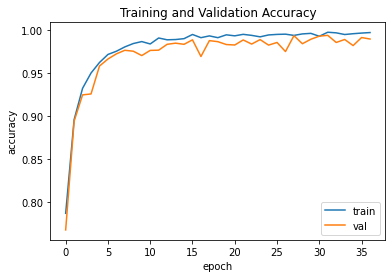

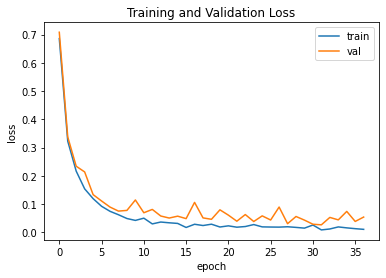

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

acc = history.history['custom_f1']
val_acc = history.history['val_custom_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(76)
plt = pyplot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['custom_f1'])
#plt.plot(history.history['val_custom_f1'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Weight Decay Regularisation

In [ ]:
from keras.regularizers import l2
def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, decay):

  # define model
  verbose, epochs, batch_size = 0, 25, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps )

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
  #decay = 1e-6
  l_decay = 0
  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(decay), bias_regularizer=l2(decay)), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(decay), bias_regularizer=l2(decay)))) 
  
  model.add(TimeDistributed(Dropout(0.1)))
  model.add(TimeDistributed(MaxPooling1D()))  
  model.add(TimeDistributed(Flatten()))
  #model.add(LSTM(100))
  model.add(LSTM(100, kernel_regularizer=l2(l_decay), recurrent_regularizer=l2(l_decay), bias_regularizer=l2(l_decay)))
  #model.add(Dropout(dropout))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  #lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = keras.optimizers.Adam(lr=1e-3)

  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=5)
  mc = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", monitor='val_custom_f1', mode='max', verbose=verbose, save_best_only=True)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])

  # fit network  
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])
  #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  #model = keras.models.load_model("my_checkpoint.h5")



 # model = keras.models.load_model("my_checkpoint.h5")
  model = keras.models.load_model("my_checkpoint.h5", custom_objects={"custom_f1": custom_f1})

  _, train_acc, train_f1 = model.evaluate(trainX, trainy, verbose=0)
  _, val_acc, val_f1 = model.evaluate(valX, valy, verbose=0)

  #acc = history.history['custom_f1']
  #val_acc = history.history['val_custom_f1']

  #loss = history.history['loss']
  #val_loss = history.history['val_loss']

  y_test_pred_cat = model.predict(testX).round()
  #cm = confusion_matrix(y_test, y_test_pred_cat)
  test_f1 = round(f1_score(y_test, y_test_pred_cat, average='macro'), 9)
  return  train_f1, val_f1 , test_f1

def run_cnn_lstm_experiment():
  decays = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()

  f_scores = list()
  train_scores = []
  val_scores = []
  test_scores = []
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  for decay in decays:        
    train_acc, val_acc, f1_final =  evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, decay)
    print ('CNN Decay: {} train_acc: {} val_acc: {} f1_final: {}'.format(decay, train_acc, val_acc, f1_final))
    train_scores.append(train_acc)
    val_scores.append(val_acc)
    test_scores.append(f1_final)
  f_scores.append(train_scores)
  f_scores.append(val_scores)
  f_scores.append(test_scores)
  print(f_scores, decays)

  

In [ ]:
history = run_cnn_lstm_experiment()

Decay: 0.1 train_acc: 0.9141985177993774 val_acc: 0.8836509585380554 f1_final: 0.760807244
Decay: 0.01 train_acc: 0.9767975807189941 val_acc: 0.971459686756134 f1_final: 0.94553357
Decay: 0.001 train_acc: 0.9928387999534607 val_acc: 0.9871367812156677 f1_final: 0.961020946
Decay: 0.0001 train_acc: 0.9944000244140625 val_acc: 0.9893279671669006 f1_final: 0.957958482
Decay: 1e-05 train_acc: 0.9964169263839722 val_acc: 0.9907488226890564 f1_final: 0.977622391
Decay: 1e-06 train_acc: 0.9970533847808838 val_acc: 0.9897899031639099 f1_final: 0.948878998
[[0.9141985177993774, 0.9767975807189941, 0.9928387999534607, 0.9944000244140625, 0.9964169263839722, 0.9970533847808838], [0.8836509585380554, 0.971459686756134, 0.9871367812156677, 0.9893279671669006, 0.9907488226890564, 0.9897899031639099], [0.760807244, 0.94553357, 0.961020946, 0.957958482, 0.977622391, 0.948878998]] [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]


In [ ]:
from keras.regularizers import l2
def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, l_decay):

  # define model
  verbose, epochs, batch_size = 0, 25, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps )

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
  decay = 1e-6

  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(decay), bias_regularizer=l2(decay)), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(decay), bias_regularizer=l2(decay)))) 
  
  model.add(TimeDistributed(Dropout(0.1)))
  model.add(TimeDistributed(MaxPooling1D()))  
  model.add(TimeDistributed(Flatten()))
  #model.add(LSTM(100))
  model.add(LSTM(100, kernel_regularizer=l2(l_decay), recurrent_regularizer=l2(l_decay), bias_regularizer=l2(l_decay)))
  #model.add(Dropout(dropout))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  #lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = keras.optimizers.Adam(lr=1e-3)

  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=5)
  mc = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", monitor='val_custom_f1', mode='max', verbose=verbose, save_best_only=True)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])

  # fit network  
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])
  #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  #model = keras.models.load_model("my_checkpoint.h5")



 # model = keras.models.load_model("my_checkpoint.h5")
  model = keras.models.load_model("my_checkpoint.h5", custom_objects={"custom_f1": custom_f1})

  _, train_acc, train_f1 = model.evaluate(trainX, trainy, verbose=0)
  _, val_acc, val_f1 = model.evaluate(valX, valy, verbose=0)

  #acc = history.history['custom_f1']
  #val_acc = history.history['val_custom_f1']

  #loss = history.history['loss']
  #val_loss = history.history['val_loss']

  y_test_pred_cat = model.predict(testX).round()
  #cm = confusion_matrix(y_test, y_test_pred_cat)
  test_f1 = round(f1_score(y_test, y_test_pred_cat, average='macro'), 9)
  return  train_f1, val_f1 , test_f1

def run_cnn_lstm_experiment():
  decays = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()

  f_scores = list()
  train_scores = []
  val_scores = []
  test_scores = []
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  for decay in decays:        
    train_acc, val_acc, f1_final =  evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy, decay)
    print ('LSTM Decay: {} train_acc: {} val_acc: {} f1_final: {}'.format(decay, train_acc, val_acc, f1_final))
    train_scores.append(train_acc)
    val_scores.append(val_acc)
    test_scores.append(f1_final)
  f_scores.append(train_scores)
  f_scores.append(val_scores)
  f_scores.append(test_scores)
  print(f_scores, decays)

  

In [ ]:
history = run_cnn_lstm_experiment()

LSTM Decay: 0.1 train_acc: 0.95266193151474 val_acc: 0.9412654638290405 f1_final: 0.839092185
LSTM Decay: 0.01 train_acc: 0.9781090021133423 val_acc: 0.9682612419128418 f1_final: 0.906072832
LSTM Decay: 0.001 train_acc: 0.9784309267997742 val_acc: 0.9776186943054199 f1_final: 0.93742703
LSTM Decay: 0.0001 train_acc: 0.9925988912582397 val_acc: 0.9823240041732788 f1_final: 0.939710598
LSTM Decay: 1e-05 train_acc: 0.9957084059715271 val_acc: 0.9896677732467651 f1_final: 0.965956138
LSTM Decay: 1e-06 train_acc: 0.9963979125022888 val_acc: 0.9890007376670837 f1_final: 0.961325031
[[0.95266193151474, 0.9781090021133423, 0.9784309267997742, 0.9925988912582397, 0.9957084059715271, 0.9963979125022888], [0.9412654638290405, 0.9682612419128418, 0.9776186943054199, 0.9823240041732788, 0.9896677732467651, 0.9890007376670837], [0.839092185, 0.906072832, 0.93742703, 0.939710598, 0.965956138, 0.961325031]] [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]


In [ ]:
from keras.regularizers import l2
def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy):

  # define model
  verbose, epochs, batch_size = 0, 100, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps )

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

  # define model
  decay = 1e-6
  l_decay = 1e-5
  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(decay), bias_regularizer=l2(decay)), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(decay), bias_regularizer=l2(decay))))
  model.add(TimeDistributed(Dropout(0.1)))
  model.add(TimeDistributed(MaxPooling1D()))
  
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100, kernel_regularizer=l2(l_decay), recurrent_regularizer=l2(l_decay), bias_regularizer=l2(l_decay)))
  #model.add(Dropout(dropout))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  #lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = keras.optimizers.Adam(lr=1e-3)

  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=8)
  mc = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", monitor='val_custom_f1', mode='max', verbose=verbose, save_best_only=True)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])

  # fit network  
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])
  print('Evaluation completed.....')
  return history

def run_cnn_lstm_experiment():
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()

  val_scores = []
  test_scores = []
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  
  return evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy)
  

In [ ]:
history = run_cnn_lstm_experiment()

Evaluation completed.....


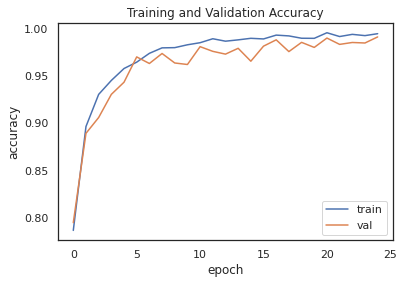

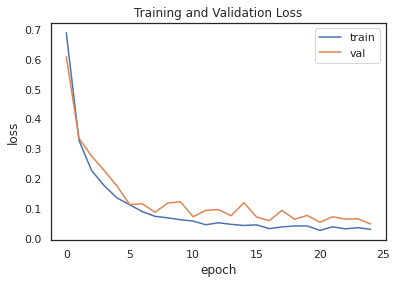

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

acc = history.history['custom_f1']
val_acc = history.history['val_custom_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(76)
plt = pyplot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['custom_f1'])
#plt.plot(history.history['val_custom_f1'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Tune Learning Rate at the End

In [ ]:
def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy):

  # define model
  verbose, epochs, batch_size = 1, 120, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps )

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

   # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)))) 
  model.add(TimeDistributed(Dropout(0.1)))
  model.add(TimeDistributed(MaxPooling1D()))
  
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100, kernel_regularizer=l2(1e-5), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5)))
  
  #model.add(Dropout(dropout))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = keras.optimizers.Adam(learning_rate=1e-8)
  #optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)

  model.compile(loss= 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  # fit network
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[lr_schedule])

  print('Training completed...')
  return history

def run_cnn_lstm_experiment():
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  return evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy)

  

In [ ]:
history = run_cnn_lstm_experiment()

Epoch 1/120
470/470 [==============================] - 2s 4ms/step - loss: 2.5199 - accuracy: 0.0485
Epoch 2/120
470/470 [==============================] - 2s 4ms/step - loss: 2.5194 - accuracy: 0.0489
Epoch 3/120
470/470 [==============================] - 2s 4ms/step - loss: 2.5190 - accuracy: 0.0488
Epoch 4/120
470/470 [==============================] - 2s 4ms/step - loss: 2.5185 - accuracy: 0.0484
Epoch 5/120
470/470 [==============================] - 2s 4ms/step - loss: 2.5178 - accuracy: 0.0498
Epoch 6/120
470/470 [==============================] - 2s 4ms/step - loss: 2.5172 - accuracy: 0.0507
Epoch 7/120
470/470 [==============================] - 2s 4ms/step - loss: 2.5165 - accuracy: 0.0499
Epoch 8/120
470/470 [==============================] - 2s 4ms/step - loss: 2.5157 - accuracy: 0.0506
Epoch 9/120
470/470 [==============================] - 2s 4ms/step - loss: 2.5147 - accuracy: 0.0506
Epoch 10/120
470/470 [==============================] - 2s 4ms/step - loss: 2.5136 - accura

(1e-08, 0.1, 0.0, 2.7)

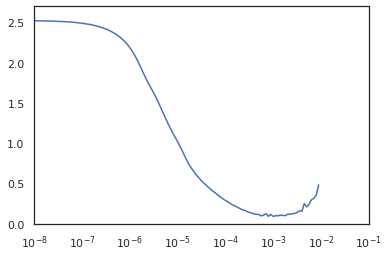

In [ ]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 2.7])

# No Context Experiment

In [ ]:
window_length = 32 #optimal window length is 32
df = load_dataset()
df = augment_dataset(df, True)
df1, df2 = split_dataset(df, 0.15)
# split train into train and valid 
df1_1, df1_2 = split_dataset(df1, 0.20)

df_train, df_val, df_test = standardize_dataset(df1_1, df1_2, df2, 'Standard')

context_as_features = False
X_train, y_train, X_val, y_val, X_test, y_test = create_sliding_windows(df_train, df_val, df_test, window_length, context_as_features)

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [ ]:
def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy):

  # define model
  verbose, epochs, batch_size = 0, 100, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps )

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

   # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)))) 
  model.add(TimeDistributed(Dropout(0.1)))
  model.add(TimeDistributed(MaxPooling1D()))
  
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100, kernel_regularizer=l2(1e-5), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5)))
  
  #model.add(Dropout(dropout))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  #lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  #optimizer = keras.optimizers.Adam(lr=1e-3)
  #optimizer = keras.optimizers.Adam(lr=3e-4)  #Testing F1 score = 0.971164295
  #optimizer = keras.optimizers.Adam(lr=5e-4)  #Testing F1 score = 0.967029476
  optimizer = keras.optimizers.Adam(lr=1e-4)

  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=8)
  mc = keras.callbacks.ModelCheckpoint("no_context.h5", monitor='val_custom_f1', mode='max', verbose=verbose, save_best_only=True)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])
  plot_model(model, show_layer_names=True, show_shapes=True, to_file='/content/drive/My Drive/HAR_Project/images/baseline_model/no_context_cnn-lstm.png')
 # model.summary()
  model.summary()
  #return
  # fit network  
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])
  #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  #model = keras.models.load_model("my_checkpoint.h5")
  print('Training completed...')
  return history

def run_cnn_lstm_experiment():
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  return evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy)

  

In [ ]:
clear_session()
history = run_cnn_lstm_experiment()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 6, 64)       1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 4, 64)       12352     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 4, 64)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               91600     
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [ ]:
#model = keras.models.load_model("my_checkpoint.h5")
no_context = keras.models.load_model("no_context.h5", custom_objects={"custom_f1": custom_f1})

batch_size = 64
trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
n_features, n_outputs = trainX.shape[2], trainy.shape[1]
n_steps = 4
n_length = int(window_length/n_steps)

testX = testX.reshape((testX.shape[0], n_steps, n_length, trainX.shape[2]))
_, accuracy, f1 = no_context.evaluate(testX, testy, batch_size=batch_size, verbose=0)
accuracy, f1

(0.9925993084907532, 0.9925928711891174)

In [ ]:
#model = keras.models.load_model("my_checkpoint.h5")
y_test_pred_cat = no_context.predict(testX).round()
#cm = confusion_matrix(y_test, y_test_pred_cat)
f1_final = round(f1_score(y_test, y_test_pred_cat, average='macro'), 9)
print(f'Testing F1 score = {f1_final}')

Testing F1 score = 0.970991489


In [ ]:
# conduct pairwise t-test

repeats = 10
batch_size = 64
trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
n_features, n_outputs = trainX.shape[2], trainy.shape[1]
n_steps = 4
n_length = int(window_length/n_steps)

testX = testX.reshape((testX.shape[0], n_steps, n_length, trainX.shape[2]))
f_scores = []
for r in range(repeats):
  history = run_cnn_lstm_experiment()
  no_context = keras.models.load_model("no_context.h5", custom_objects={"custom_f1": custom_f1})
  y_test_pred_cat = no_context.predict(testX).round()
  #cm = confusion_matrix(y_test, y_test_pred_cat)
  f1_final = round(f1_score(y_test, y_test_pred_cat, average='macro'), 9)
  f_scores.append(f1_final)
  
  print('> #%d: %.3f' % (r+1, f1_final))
data1 = f_scores
print (f_scores)




Training completed...
> #1: 0.955
Training completed...
> #2: 0.967
Training completed...
> #3: 0.970
Training completed...
> #4: 0.960
Training completed...
> #5: 0.977
Training completed...
> #6: 0.969
Training completed...
> #7: 0.970
Training completed...
> #8: 0.965
Training completed...
> #9: 0.974
Training completed...
> #10: 0.966
[0.954906667, 0.967114448, 0.969511079, 0.9604627, 0.976500426, 0.968936004, 0.970104307, 0.965172032, 0.97448577, 0.966134716]


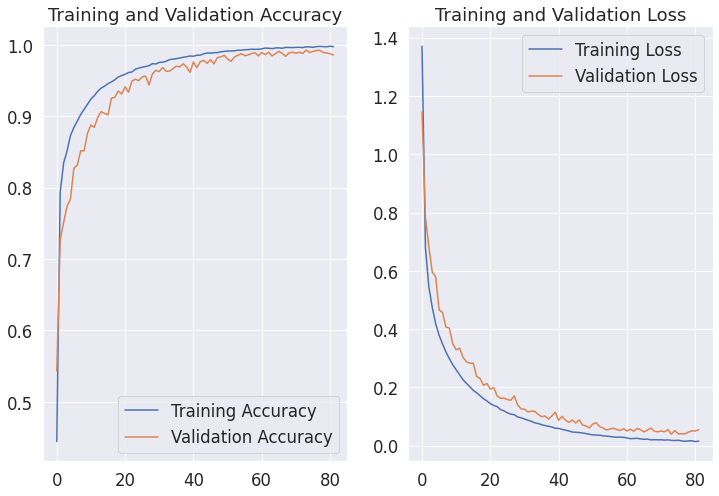

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
acc = history.history['custom_f1']
val_acc = history.history['val_custom_f1']



loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(76)
plt = pyplot
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

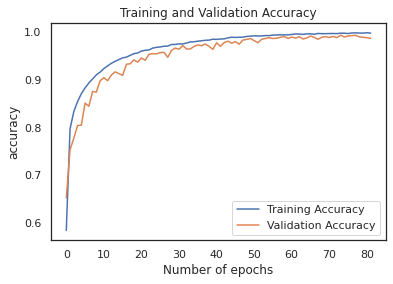

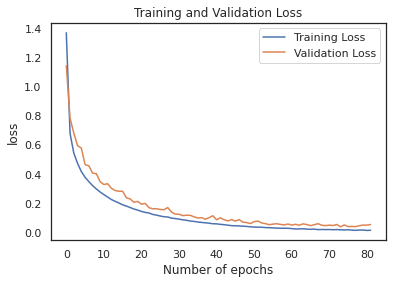

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

acc = history.history['custom_f1']
val_acc = history.history['val_custom_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']
sns.set(style="white", font_scale=1)
#epochs_range = range(76)
plt = pyplot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['custom_f1'])
#plt.plot(history.history['val_custom_f1'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Number of epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('Number of epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
#trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
#cols = ['AscendingStairs','ClimbingDownStairs','ClimbingUpStairs','DescendingStairs','Driving','Hiking','Jogging','Lying','Running','Sitting','Standing']
#cols = np.sort(df_test.activity.unique()).tolist()
cols = enc.categories_[0].tolist()
Y_test = np.argmax(testy, axis=1) # Convert one-hot to index
#y_pred = model.predict_classes(testX)
y_pred = np.argmax(no_context.predict(testX), axis=-1)

no_context_report = classification_report(Y_test, y_pred, target_names=cols, digits=6, output_dict=True)
df_no_context = pd.DataFrame(no_context_report).transpose()
df_no_context.to_csv('/content/drive/My Drive/HAR_Project/Result_Analysis/f-score_NoContext.csv')

print(classification_report(Y_test, y_pred, target_names=cols, digits=6))




                     precision    recall  f1-score   support

          1-Jogging   0.993827  0.996904  0.995363       323
            1-Lying   0.999372  1.000000  0.999686      1591
          1-Running   1.000000  1.000000  1.000000        75
          1-Sitting   0.989796  0.994872  0.992327       195
         1-Standing   0.998322  0.995816  0.997067      1195
          1-Walking   0.991211  0.994389  0.992797      2495
 2-Ascending Stairs   0.972727  0.955357  0.963964       112
2-Descending Stairs   0.930233  0.909091  0.919540        44
    2-Elevator Down   0.970149  0.984848  0.977444       198
      2-Elevator Up   0.976109  0.993056  0.984509       288
2-Mountain Climbing   0.975610  0.754717  0.851064        53
    2-Riding in car   1.000000  0.980769  0.990291        52

           accuracy                       0.992599      6621
          macro avg   0.983113  0.963318  0.972004      6621
       weighted avg   0.992580  0.992599  0.992468      6621



In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  plt = pyplot
  class_names = [i.replace('1-','' ) for i in class_names]
  class_names = [i.replace('2-','' ) for i in class_names]
  class_names = [i.replace('Elevetor','Elevator' ) for i in class_names]
  cm = confusion_matrix(y_true, y_pred)
  
  fig, ax = plt.subplots(figsize=(18, 16)) 
  sns.set(font_scale=1.5)



  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=12), 
      ax=ax
  )
  
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label', )
  #ax.xaxis.set_label_position('top')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

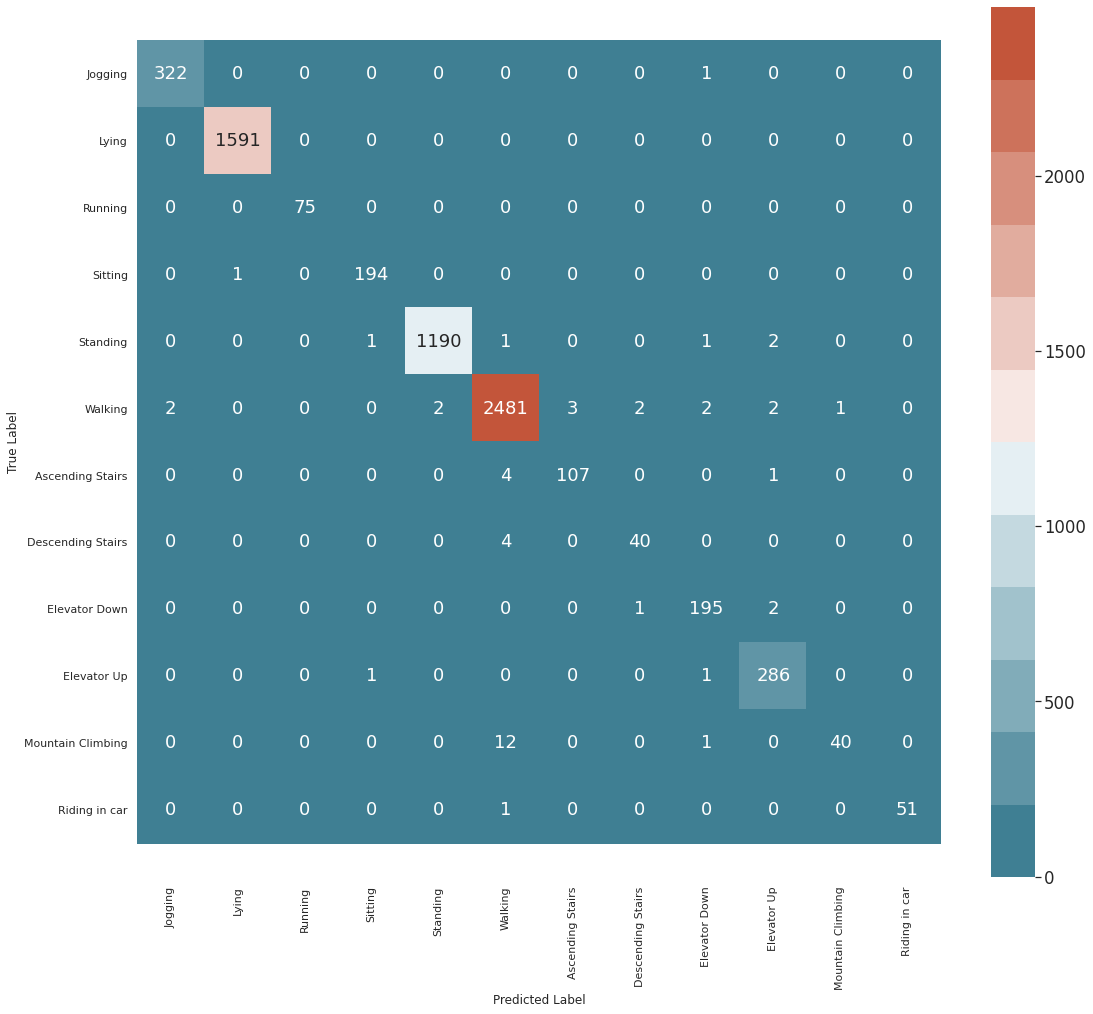

In [ ]:
y_pred = no_context.predict(testX, verbose=0)
plot_cm(
   
    enc.inverse_transform(y_test),
    enc.inverse_transform(y_pred),    
    enc.categories_[0]
)

In [ ]:
imp = no_context.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

AttributeError: ignored

In [ ]:
# show importance scores
print(no_context.feature_importances_)
# plot importance scores
names = df_train.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, no_context.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

AttributeError: ignored

# Context as Feature Experiment

In [ ]:
window_length = 32 #optimal window length is 32
df = load_dataset()
df = augment_dataset(df, True)
df1, df2 = split_dataset(df, 0.15)
# split train into train and valid 
df1_1, df1_2 = split_dataset(df1, 0.20)

df_train, df_val, df_test = standardize_dataset(df1_1, df1_2, df2, 'Standard')

context_as_features = True
X_train, y_train, X_val, y_val, X_test, y_test = create_sliding_windows(df_train, df_val, df_test, window_length, context_as_features)


enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [ ]:
def evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy):

  # define model
  verbose, epochs, batch_size = 0, 100, 64
  n_features, n_outputs = trainX.shape[2], trainy.shape[1]
  # reshape data into time steps of sub-sequences
  n_steps = 4
  n_length = int(window_length/n_steps )

  trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
  valX = valX.reshape((valX.shape[0], n_steps, n_length, n_features))
  testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)), input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)))) 
  model.add(TimeDistributed(Dropout(0.1)))
  model.add(TimeDistributed(MaxPooling1D()))
  
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100, kernel_regularizer=l2(1e-5), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5)))
  #model.add(Dropout(dropout))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  #lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
  #optimizer = keras.optimizers.Adam(lr=1e-3)
  #optimizer = keras.optimizers.Adam(lr=5e-4)
  optimizer = keras.optimizers.Adam(lr=1e-4)

  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=8)
  mc = keras.callbacks.ModelCheckpoint("context_as_feature.h5", monitor='val_custom_f1', mode='max', verbose=verbose, save_best_only=True)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', custom_f1])
  plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/HAR_Project/images/baseline_model/context_as_feature_cnn-lstm.png')
  
  
  model.summary()
  #return
  # fit network  
  history_exp2 = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[mc, es])
  #history_exp2 = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=verbose, callbacks=[Metrics(validation=(valX, valy)), mc, es])
  #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  #model = keras.models.load_model("my_checkpoint.h5")
  print('Training completed...')
  return history_exp2

def run_cnn_lstm_experiment():
  #load data
  #trainX, trainy, testX, testy = load_preprocessed_data()
  trainX, trainy, valX, valy, testX, testy = X_train, y_train, X_val, y_val, X_test, y_test
  return evaluate_cnn_lstm_model(trainX, trainy, valX, valy, testX, testy)

 

In [ ]:
clear_session()
history_exp2 = run_cnn_lstm_experiment()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 6, 64)       2176      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 4, 64)       12352     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 4, 64)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               91600     
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [ ]:

context_as_feature = keras.models.load_model("context_as_feature.h5", custom_objects={"custom_f1": custom_f1})

batch_size = 64
#batch_size = 128 #Testing F1 score = 0.983003715
trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
n_features, n_outputs = trainX.shape[2], trainy.shape[1]
n_steps = 4
n_length = int(window_length/n_steps)

testX = testX.reshape((testX.shape[0], n_steps, n_length, trainX.shape[2]))
_, accuracy, f1 = context_as_feature.evaluate(testX, testy, batch_size=batch_size, verbose=0)
accuracy, f1

(0.9919951558113098, 0.9920195937156677)

In [ ]:
y_test_pred_cat = context_as_feature.predict(testX).round()
#cm = confusion_matrix(y_test, y_test_pred_cat)
f1_final = round(f1_score(y_test, y_test_pred_cat, average='macro'), 9)
print(f'Testing F1 score = {f1_final}')

Testing F1 score = 0.980330597


In [ ]:
# conduct pairwise t-test

repeats = 10
batch_size = 32
trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
n_features, n_outputs = trainX.shape[2], trainy.shape[1]
n_steps = 4
n_length = int(window_length/n_steps)

testX = testX.reshape((testX.shape[0], n_steps, n_length, trainX.shape[2]))
f_scores = []
for r in range(repeats):
  history_exp2 = run_cnn_lstm_experiment()
  no_context = keras.models.load_model("context_as_feature.h5", custom_objects={"custom_f1": custom_f1})
  y_test_pred_cat = no_context.predict(testX).round()
  #cm = confusion_matrix(y_test, y_test_pred_cat)
  f1_final = round(f1_score(y_test, y_test_pred_cat, average='macro'), 9)
  f_scores.append(f1_final)
  
  print('> #%d: %.3f' % (r+1, f1_final))
data2 = f_scores
print (f_scores)

Training completed...
> #1: 0.989
Training completed...
> #2: 0.989
Training completed...
> #3: 0.986
Training completed...
> #4: 0.986
Training completed...
> #5: 0.985
Training completed...
> #6: 0.986
Training completed...
> #7: 0.979
Training completed...
> #8: 0.982
Training completed...
> #9: 0.981
Training completed...
> #10: 0.986
[0.988843732, 0.988695665, 0.986141593, 0.985694544, 0.985133622, 0.985867611, 0.978543289, 0.982241187, 0.980738841, 0.986270088]


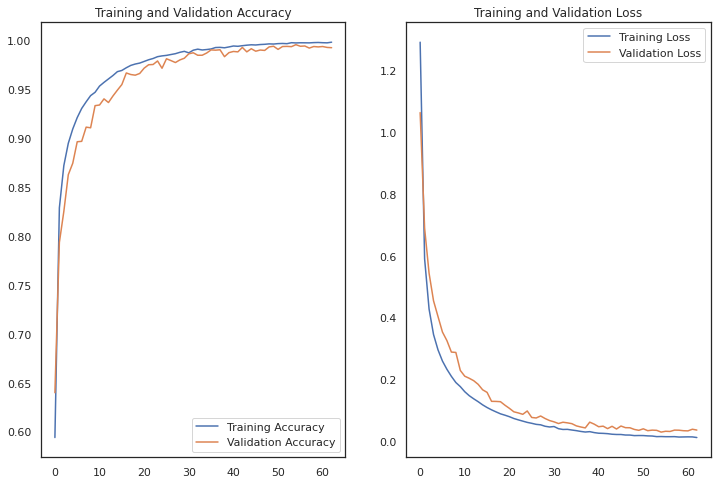

In [ ]:
acc = history_exp2.history['accuracy']
val_acc = history_exp2.history['val_accuracy']

loss = history_exp2.history['loss']
val_loss = history_exp2.history['val_loss']
sns.set(style="white", font_scale=1.0)
#epochs_range = range(76)
plt = pyplot
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

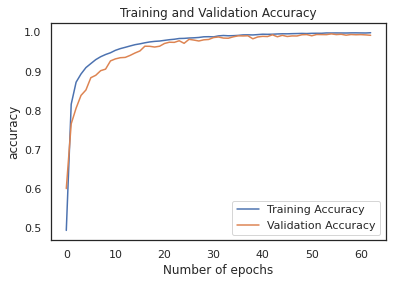

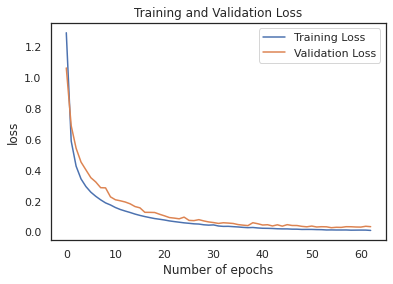

In [ ]:
acc = history_exp2.history['accuracy']
val_acc = history_exp2.history['val_accuracy']

acc = history_exp2.history['custom_f1']
val_acc = history_exp2.history['val_custom_f1']

loss = history_exp2.history['loss']
val_loss = history_exp2.history['val_loss']

sns.set(style="white", font_scale=1.0)

#epochs_range = range(76)
plt = pyplot 
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.plot(history_exp2.history['custom_f1'])
plt.plot(history_exp2.history['val_custom_f1'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Number of epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

plt.plot(history_exp2.history['loss'])
plt.plot(history_exp2.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('Number of epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

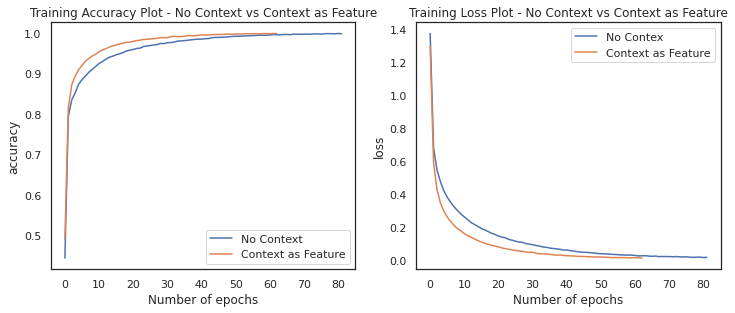

In [ ]:
acc = history.history['custom_f1']
val_acc = history.history['val_custom_f1']

acc_2 = history_exp2.history['custom_f1']
val_acc_2 = history_exp2.history['val_custom_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

loss_2 = history_exp2.history['loss']
val_loss_2 = history_exp2.history['val_loss']

#epochs_range = range(76)
plt = pyplot
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot( acc, label='No Context')
plt.plot( acc_2, label='Context as Feature')
plt.legend(loc='lower right')
plt.title('Training Accuracy Plot - No Context vs Context as Feature')
plt.ylabel('accuracy')
plt.xlabel('Number of epochs')

plt.subplot(2, 2, 2)
plt.plot(loss, label='No Contex')
plt.plot(loss_2, label='Context as Feature')
plt.legend(loc='upper right')
plt.title('Training Loss Plot - No Context vs Context as Feature')
plt.ylabel('loss')
plt.xlabel('Number of epochs')
plt.show()

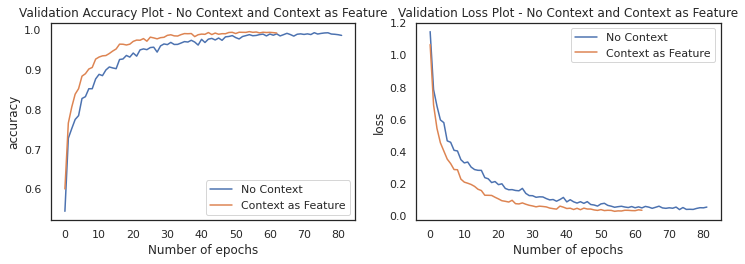

In [ ]:
acc = history.history['custom_f1']
val_acc = history.history['val_custom_f1']

acc_2 = history_exp2.history['custom_f1']
val_acc_2 = history_exp2.history['val_custom_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

loss_2 = history_exp2.history['loss']
val_loss_2 = history_exp2.history['val_loss']

#epochs_range = range(76)
plt = pyplot
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot( val_acc, label='No Context')
plt.plot( val_acc_2, label='Context as Feature')
plt.legend(loc='lower right')
plt.title('Validation Accuracy Plot - No Context and Context as Feature')
plt.ylabel('accuracy')
plt.xlabel('Number of epochs')

plt.subplot(2, 2, 2)
plt.plot(val_loss, label='No Context')
plt.plot(val_loss_2, label='Context as Feature')
plt.legend(loc='upper right')
plt.title('Validation Loss Plot - No Context and Context as Feature')
plt.ylabel('loss')
plt.xlabel('Number of epochs')
plt.show()

# Compare Classification Report


1.   no_context (history)
2.   context_as_feature (history_exp2)



In [ ]:
from sklearn.metrics import classification_report

cols = enc.categories_[0].tolist()
Y_test = np.argmax(testy, axis=1) # Convert one-hot to index

y_pred = np.argmax(context_as_feature.predict(testX), axis=-1)

context_report = classification_report(Y_test, y_pred, target_names=cols, digits=6, output_dict=True)
df_context = pd.DataFrame(context_report).transpose()
df_context.to_csv('/content/drive/My Drive/HAR_Project/Result_Analysis/f-score_ContextAsFeature.csv')


print(classification_report(Y_test, y_pred, target_names=cols, digits=6))


                     precision    recall  f1-score   support

          1-Jogging   0.990769  0.996904  0.993827       323
            1-Lying   0.999372  1.000000  0.999686      1591
          1-Running   1.000000  0.986667  0.993289        75
          1-Sitting   0.965174  0.994872  0.979798       195
         1-Standing   0.997487  0.996653  0.997070      1195
          1-Walking   0.998780  0.984369  0.991522      2495
 2-Ascending Stairs   0.810219  0.991071  0.891566       112
2-Descending Stairs   0.955556  0.977273  0.966292        44
    2-Elevator Down   0.994924  0.989899  0.992405       198
      2-Elevator Up   0.989619  0.993056  0.991334       288
2-Mountain Climbing   0.929825  1.000000  0.963636        53
    2-Riding in car   1.000000  0.980769  0.990291        52

           accuracy                       0.991995      6621
          macro avg   0.969310  0.990961  0.979226      6621
       weighted avg   0.992789  0.991995  0.992199      6621



In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  plt = pyplot
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 

  class_names = [i.replace('1-','' ) for i in class_names]
  class_names = [i.replace('2-','' ) for i in class_names]
  class_names = [i.replace('Elevetor','Elevator' ) for i in class_names]

  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d",
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )
  sns.set(font_scale=1.5)
  
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!



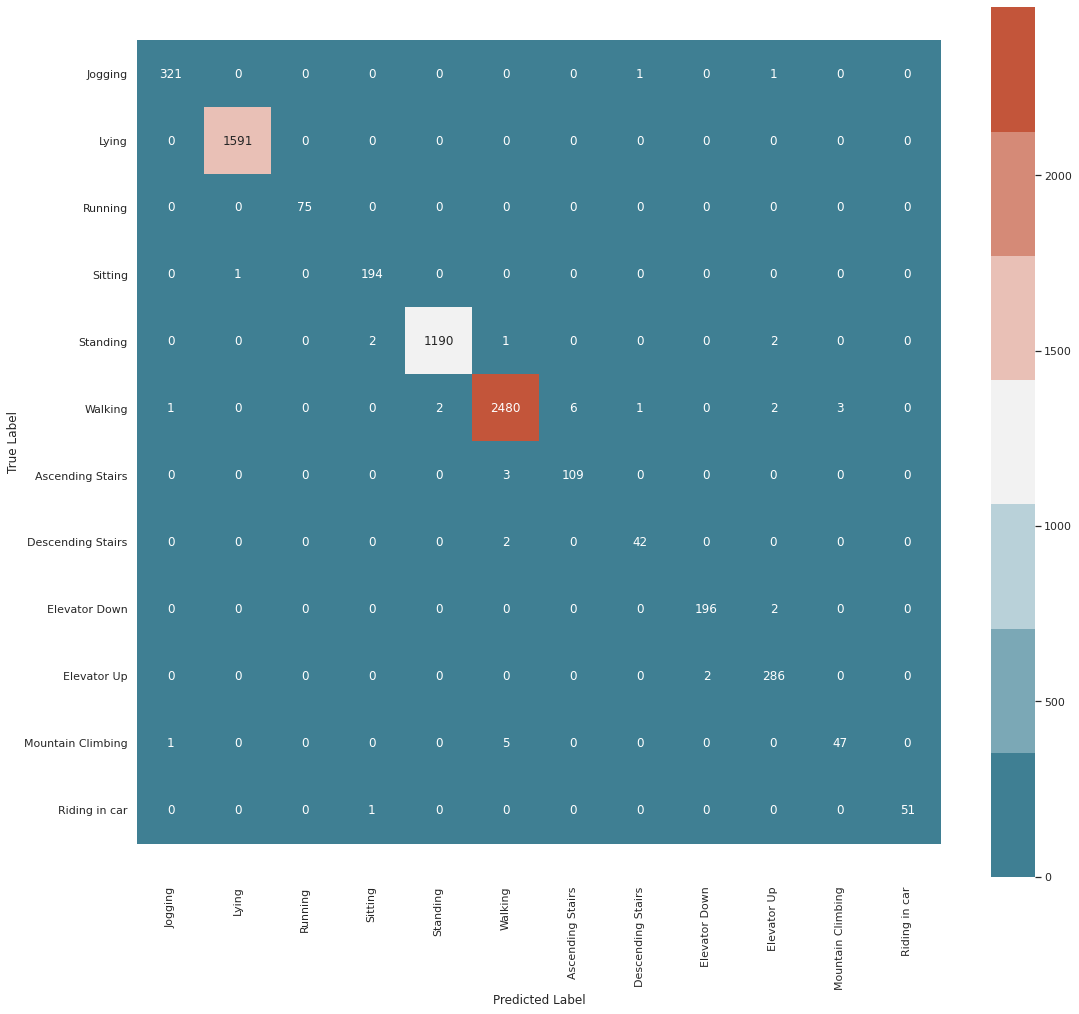

In [ ]:
y_pred = context_as_feature.predict(testX, verbose=0)
plot_cm(
   
    enc.inverse_transform(y_test),
    enc.inverse_transform(y_pred),
    enc.categories_[0]
)

In [ ]:
enc.categories_[0]

array(['AscendingStairs', 'ClimbingDownStairs', 'ClimbingUpStairs',
       'DescendingStairs', 'Driving', 'Jogging', 'Lying', 'Running',
       'Sitting', 'Standing', 'Walking'], dtype='<U18')

# Pairwise t-test

In [ ]:
# t-test for independent samples
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
from scipy.stats import t
#Epoch set at 25
data1 = [0.992277043, 0.990596979, 0.991224639, 0.991453752, 0.99050587, 0.988113457, 0.988548392, 0.991170538, 0.991649187, 0.989443724]
data2 = [0.99329758, 0.995880298, 0.994910208, 0.994154057, 0.994034738, 0.994713358, 0.994574143, 0.994735299, 0.993406514, 0.994076605]
data2 = [0.976628366, 0.981059949, 0.983760904, 0.972929973, 0.981225987, 0.985289773, 0.978517754, 0.977456939, 0.978528545, 0.980799221]
#earlystopping activated
data1 = [0.968440582, 0.960714401, 0.963739323, 0.964304042, 0.957661937, 0.9636048, 0.967238756, 0.965092046, 0.963334044, 0.963798087]
data2 = [0.98020656, 0.984323412, 0.981372718, 0.976972947, 0.983525071, 0.986327692, 0.978197517, 0.979542802, 0.9780044, 0.977633419]


# function for calculating the t-test for two independent samples
def independent_ttest(data1, data2, alpha):
	# calculate means
	mean1, mean2 = mean(data1), mean(data2)
	# calculate standard errors
	se1, se2 = sem(data1), sem(data2)
	# standard error on the difference between the samples
	sed = sqrt(se1**2.0 + se2**2.0)
	# calculate the t statistic
	t_stat = (mean1 - mean2) / sed
	# degrees of freedom
	df = len(data1) + len(data2) - 2
	# calculate the critical value
	cv = t.ppf(1.0 - alpha, df)
	# calculate the p-value
	p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
	# return everything
	return t_stat, df, cv, p
 
# seed the random number generator
seed(1)
# generate two independent samples

# calculate the t test
alpha = 0.05
t_stat, df, cv, p = independent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.6f' % (t_stat, df, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')
# interpret via p-value
if p > alpha:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')

t=-12.085, df=18, cv=1.734, p=0.000000
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


In [ ]:

# Student's t-test for independent samples
from numpy.random import seed
from numpy.random import randn
from scipy.stats import ttest_ind
# seed the random number generator
seed(1)
# generate two independent samples

# compare samples
stat, p = ttest_ind(data1, data2)
print('t=%.3f, p=%.6f' % (stat, p))


t=-7.753, p=0.000000
t=-7.753, p=0.000000


In [ ]:
# t-test for dependent samples
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import t
 
# function for calculating the t-test for two dependent samples
def dependent_ttest(data1, data2, alpha):
	# calculate means
	mean1, mean2 = mean(data1), mean(data2)
	# number of paired samples
	n = len(data1)
	# sum squared difference between observations
	d1 = sum([(data1[i]-data2[i])**2 for i in range(n)])
	# sum difference between observations
	d2 = sum([data1[i]-data2[i] for i in range(n)])
	# standard deviation of the difference between means
	sd = sqrt((d1 - (d2**2 / n)) / (n - 1))
	# standard error of the difference between the means
	sed = sd / sqrt(n)
	# calculate the t statistic
	t_stat = (mean1 - mean2) / sed
	# degrees of freedom
	df = n - 1
	# calculate the critical value
	cv = t.ppf(1.0 - alpha, df)
	# calculate the p-value
	p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
	# return everything
	return t_stat, df, cv, p
 
# seed the random number generator
seed(1)
# generate two independent samples (pretend they are dependent)

# calculate the t test
alpha = 0.05
t_stat, df, cv, p = dependent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.6f' % (t_stat, df, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')
# interpret via p-value
if p > alpha:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')

t=-6.546, df=9, cv=1.833, p=0.000106
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


In [ ]:
# Paired Student's t-test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import ttest_rel
# seed the random number generator
seed(1)
# generate two independent samples

# compare samples
stat, p = ttest_rel(data1, data2)
print('Statistics=%.3f, p=%.5f' % (stat, p))

Statistics=-6.546, p=0.00011


In [ ]:
scores_m, score_std = mean(data1), std(data1)
print('%s: %.3f F-Score (+/- %.3f)' % ('No Context', scores_m, score_std))

No Context: 0.967 F-Score (+/- 0.006)


In [ ]:
scores_m, score_std = mean(data2), std(data2)
print('%s: %.3f F-Score (+/- %.3f)' % ('Context as Feature', scores_m, score_std))

Context as Feature: 0.985 F-Score (+/- 0.003)
